# GPL Paper Section 4.1.2 Experiment: Quadratic Hamiltonian with L1 Prior

This code attempts to learn 2D prior $J(x) = \|x\|_1$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian
$H(p) = \frac{1}{2}\|p\|_2^2$.
The LPN learns the function $\psi(y) = J^*(y) - \frac{1}{2}\|y\|_2^2$.
Training data uses samples $\{y_j,\psi(y_j)\}$ where $\psi(y_j) = \frac{1}{2}\|y_j\|_2^2 - S(y_j,1)$, and,
$S(y_j,1) = \min_{x \in \mathbb{R}^d} \{\frac{1}{2}\|x-y_j\|_2^2 + \|x\|_1\}$ (Moreau envelope of $J(x)=\|x\|_1$ at $t=1$).

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_4_1_2_quadratic_2D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters for Sec 4.1.2 L1 Prior Experiment ---
dim_exp = 2 
data_points_exp = 20000 
iterations_exp_initial = 1 
iterations_exp_long = 500000 
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 100 


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
#eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)

def prox_l1_vec(y, t_lambda):
    """ Element-wise proximal operator of t_lambda*||x||_1 (soft-thresholding). """
    return np.sign(y) * np.maximum(np.abs(y) - t_lambda, 0)

def hjsol_true_quadratic_l1(y_points,n=1.0, t=1.0): # y_points is N x dim
    """
    Computes S(y, t=1) for J(x)=||x||_1.
    S(y, 1) = ||x||_1 + nt/2 }
    """
    t_moreau = 1.0
    prox_y = prox_l1_vec(y_points, t_moreau) # element-wise for N x dim
    s_values = np.sum(np.abs(prox_y), axis=1) +n * t/2 # L1 norm for each vector y_j 
    return s_values # N-dimensional array

def prior_true_quadratic_l1(y_points): # y_points is N x dim
    """ Computes the true prior J(y) = ||y||_1. """
    return np.sum(np.abs(y_points), axis=1) # N-dimensional array

def cvx_true_quadratic_l1(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = 0.5*||y||_2^2 - S(y, t=1) for J(x)=||x||_1.
    """
    s_y_1 = hjsol_true_quadratic_l1(y_points)
    psi_y = 0.5 * euclid_norm_sq(y_points) - s_y_1
    return psi_y # N-dimensional array

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est

def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_quadratic_l1(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_quadratic_l1(x1_0_points)
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_quadratic_l1(x2_0_points)
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=\\|x\\|_1$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_quadratic_l1(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim={dim}) ---")
    cross_sections_plots_quadratic_l1(model, a, spacing, INVERT_MODE, dim)



In [4]:

def exp_func(x, gamma):
    # Ensure x is a 1D tensor for vector_norm if it comes in as N x 1
    if x.ndim > 1 and x.shape[1] == 1:
        x = x.squeeze(1)
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim=-1)/ gamma) ** 2)) + 1.0

# --- Generate Training Data (using Moreau envelope target as per notebook) ---

In [5]:
# --- Generate Training Data ---
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))

cvx_samples_exp_np = cvx_true_quadratic_l1(y_j_exp_np)
cvx_samples_exp_np = cvx_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float()
cvx_samples_exp_tensor = torch.from_numpy(cvx_samples_exp_np).float()
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, cvx_samples_exp_tensor shape {cvx_samples_exp_tensor.shape}")
# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
cvx_samples_exp_tensor = cvx_samples_exp_tensor.to(device)

Generated training data: y_j_exp_tensor shape torch.Size([20000, 2]), cvx_samples_exp_tensor shape torch.Size([20000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L1 loss -- Train

In [7]:

print("--- Training LPN for J(x)=||x||_1 (Quadratic H) ---")
lpn_model_quad_l1 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_quad_l1 = torch.optim.Adam(lpn_model_quad_l1.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=1,gamma_loss=None)

for g in optimizer_quad_l1.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_quad_l1.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=1,gamma_loss=None)

torch.save(lpn_model_quad_l1.state_dict(), os.path.join(MODEL_DIR, "QuadraticH_L1prior_l1.pth"))

--- Training LPN for J(x)=||x||_1 (Quadratic H) ---


iteration 0 loss 2.048428535461426
iteration 0 loss 37.64513397216797


iteration 500 loss 1.2208408117294312


iteration 1000 loss 1.0267224311828613


iteration 1500 loss 0.9343757629394531


iteration 2000 loss 0.8008280992507935


iteration 2500 loss 0.6010769009590149


iteration 3000 loss 0.34880492091178894


iteration 3500 loss 0.16357377171516418


iteration 4000 loss 0.12166603654623032


iteration 4500 loss 0.10339435935020447


iteration 5000 loss 0.09182068705558777


iteration 5500 loss 0.08321928977966309


iteration 6000 loss 0.07730651646852493


iteration 6500 loss 0.07343947887420654


iteration 7000 loss 0.07143113762140274


iteration 7500 loss 0.06727979332208633


iteration 8000 loss 0.06579821556806564


iteration 8500 loss 0.06307847797870636


iteration 9000 loss 0.06178904324769974


iteration 9500 loss 0.060476403683423996


iteration 10000 loss 0.05939098447561264


iteration 10500 loss 0.05803023651242256


iteration 11000 loss 0.05725793167948723


iteration 11500 loss 0.057008903473615646


iteration 12000 loss 0.05571930855512619


iteration 12500 loss 0.05531502515077591


iteration 13000 loss 0.05420798063278198


iteration 13500 loss 0.05335110425949097


iteration 14000 loss 0.05273263901472092


iteration 14500 loss 0.0525154285132885


iteration 15000 loss 0.05200446769595146


iteration 15500 loss 0.05216274783015251


iteration 16000 loss 0.05142982676625252


iteration 16500 loss 0.05073997378349304


iteration 17000 loss 0.05036192387342453


iteration 17500 loss 0.05327579751610756


iteration 18000 loss 0.04988609999418259


iteration 18500 loss 0.04953978210687637


iteration 19000 loss 0.04910431429743767


iteration 19500 loss 0.048772189766168594


iteration 20000 loss 0.051265764981508255


iteration 20500 loss 0.04861193150281906


iteration 21000 loss 0.05080115795135498


iteration 21500 loss 0.04768849536776543


iteration 22000 loss 0.04885125160217285


iteration 22500 loss 0.04720546677708626


iteration 23000 loss 0.046944983303546906


iteration 23500 loss 0.0469902828335762


iteration 24000 loss 0.046491723507642746


iteration 24500 loss 0.05101606994867325


iteration 25000 loss 0.046427033841609955


iteration 25500 loss 0.04642665386199951


iteration 26000 loss 0.04745164141058922


iteration 26500 loss 0.04600369930267334


iteration 27000 loss 0.045971039682626724


iteration 27500 loss 0.04696156457066536


iteration 28000 loss 0.045529596507549286


iteration 28500 loss 0.04551488533616066


iteration 29000 loss 0.04650033637881279


iteration 29500 loss 0.04503611847758293


iteration 30000 loss 0.04505890980362892


iteration 30500 loss 0.045971546322107315


iteration 31000 loss 0.0445496030151844


iteration 31500 loss 0.0447465255856514


iteration 32000 loss 0.04559957608580589


iteration 32500 loss 0.04423394426703453


iteration 33000 loss 0.04423706606030464


iteration 33500 loss 0.0451301671564579


iteration 34000 loss 0.04373709484934807


iteration 34500 loss 0.04395657405257225


iteration 35000 loss 0.04469502344727516


iteration 35500 loss 0.0433555506169796


iteration 36000 loss 0.04380585998296738


iteration 36500 loss 0.0444105826318264


iteration 37000 loss 0.04282958433032036


iteration 37500 loss 0.04255586490035057


iteration 38000 loss 0.0432581789791584


iteration 38500 loss 0.04240139201283455


iteration 39000 loss 0.04211866110563278


iteration 39500 loss 0.043356820940971375


iteration 40000 loss 0.04182175174355507


iteration 40500 loss 0.042589325457811356


iteration 41000 loss 0.042502086609601974


iteration 41500 loss 0.0417400524020195


iteration 42000 loss 0.04124898836016655


iteration 42500 loss 0.04230139032006264


iteration 43000 loss 0.041585925966501236


iteration 43500 loss 0.04148774966597557


iteration 44000 loss 0.041438788175582886


iteration 44500 loss 0.04059857130050659


iteration 45000 loss 0.0409877710044384


iteration 45500 loss 0.04087015986442566


iteration 46000 loss 0.0406871996819973


iteration 46500 loss 0.04091344401240349


iteration 47000 loss 0.040404725819826126


iteration 47500 loss 0.04030531644821167


iteration 48000 loss 0.040084149688482285


iteration 48500 loss 0.0404818132519722


iteration 49000 loss 0.039975330233573914


iteration 49500 loss 0.04012242332100868


iteration 50000 loss 0.04004378616809845


iteration 50500 loss 0.03976314887404442


iteration 51000 loss 0.03970196843147278


iteration 51500 loss 0.0396689772605896


iteration 52000 loss 0.039625294506549835


iteration 52500 loss 0.039462946355342865


iteration 53000 loss 0.039414793252944946


iteration 53500 loss 0.0391327366232872


iteration 54000 loss 0.03918103501200676


iteration 54500 loss 0.0390448123216629


iteration 55000 loss 0.038968414068222046


iteration 55500 loss 0.03884580731391907


iteration 56000 loss 0.03873009979724884


iteration 56500 loss 0.0386844277381897


iteration 57000 loss 0.03859058767557144


iteration 57500 loss 0.03856063634157181


iteration 58000 loss 0.0384509339928627


iteration 58500 loss 0.0384228453040123


iteration 59000 loss 0.03833330050110817


iteration 59500 loss 0.038198623806238174


iteration 60000 loss 0.03811829164624214


iteration 60500 loss 0.03810640051960945


iteration 61000 loss 0.037966419011354446


iteration 61500 loss 0.03787078335881233


iteration 62000 loss 0.03777332231402397


iteration 62500 loss 0.037607111036777496


iteration 63000 loss 0.03754881024360657


iteration 63500 loss 0.03745588660240173


iteration 64000 loss 0.03734070807695389


iteration 64500 loss 0.037260327488183975


iteration 65000 loss 0.03722108528017998


iteration 65500 loss 0.03718061000108719


iteration 66000 loss 0.03713490441441536


iteration 66500 loss 0.03694479167461395


iteration 67000 loss 0.03688962385058403


iteration 67500 loss 0.0367845818400383


iteration 68000 loss 0.036767151206731796


iteration 68500 loss 0.03672497346997261


iteration 69000 loss 0.03662129491567612


iteration 69500 loss 0.036598414182662964


iteration 70000 loss 0.03644752874970436


iteration 70500 loss 0.03646313399076462


iteration 71000 loss 0.0364316962659359


iteration 71500 loss 0.0363137386739254


iteration 72000 loss 0.03614671900868416


iteration 72500 loss 0.03609154000878334


iteration 73000 loss 0.036042701452970505


iteration 73500 loss 0.03604203835129738


iteration 74000 loss 0.0359901525080204


iteration 74500 loss 0.03590695187449455


iteration 75000 loss 0.03585542365908623


iteration 75500 loss 0.0357498936355114


iteration 76000 loss 0.03571002185344696


iteration 76500 loss 0.03556673601269722


iteration 77000 loss 0.03548625856637955


iteration 77500 loss 0.03558487817645073


iteration 78000 loss 0.03550200164318085


iteration 78500 loss 0.03530459478497505


iteration 79000 loss 0.03531888499855995


iteration 79500 loss 0.035184744745492935


iteration 80000 loss 0.0351913720369339


iteration 80500 loss 0.03513503819704056


iteration 81000 loss 0.03503826633095741


iteration 81500 loss 0.035005390644073486


iteration 82000 loss 0.034919846802949905


iteration 82500 loss 0.034862224012613297


iteration 83000 loss 0.034872788935899734


iteration 83500 loss 0.03474355861544609


iteration 84000 loss 0.03466951102018356


iteration 84500 loss 0.03462115302681923


iteration 85000 loss 0.034581538289785385


iteration 85500 loss 0.03453107178211212


iteration 86000 loss 0.03446737676858902


iteration 86500 loss 0.03441864252090454


iteration 87000 loss 0.03434621915221214


iteration 87500 loss 0.03432794287800789


iteration 88000 loss 0.03426290303468704


iteration 88500 loss 0.03416375070810318


iteration 89000 loss 0.034123316407203674


iteration 89500 loss 0.03411412239074707


iteration 90000 loss 0.03404541686177254


iteration 90500 loss 0.03401842713356018


iteration 91000 loss 0.033971384167671204


iteration 91500 loss 0.033917542546987534


iteration 92000 loss 0.03386466205120087


iteration 92500 loss 0.033786337822675705


iteration 93000 loss 0.033775657415390015


iteration 93500 loss 0.03367917239665985


iteration 94000 loss 0.0336909145116806


iteration 94500 loss 0.033574722707271576


iteration 95000 loss 0.03358206897974014


iteration 95500 loss 0.033486366271972656


iteration 96000 loss 0.03346600756049156


iteration 96500 loss 0.0334387831389904


iteration 97000 loss 0.03338218852877617


iteration 97500 loss 0.033360905945301056


iteration 98000 loss 0.03327082470059395


iteration 98500 loss 0.03323864936828613


iteration 99000 loss 0.03320319578051567


iteration 99500 loss 0.03314109519124031


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.03311771899461746


iteration 100500 loss 0.032468732446432114


iteration 101000 loss 0.032453473657369614


iteration 101500 loss 0.03243771567940712


iteration 102000 loss 0.03241985663771629


iteration 102500 loss 0.03239850327372551


iteration 103000 loss 0.03237219899892807


iteration 103500 loss 0.03234033286571503


iteration 104000 loss 0.03230251371860504


iteration 104500 loss 0.03226512670516968


iteration 105000 loss 0.03222908079624176


iteration 105500 loss 0.032194554805755615


iteration 106000 loss 0.03216428682208061


iteration 106500 loss 0.03213346749544144


iteration 107000 loss 0.03210308030247688


iteration 107500 loss 0.0320759192109108


iteration 108000 loss 0.03204727545380592


iteration 108500 loss 0.03202100843191147


iteration 109000 loss 0.03199557587504387


iteration 109500 loss 0.03224392607808113


iteration 110000 loss 0.031944435089826584


iteration 110500 loss 0.03191857039928436


iteration 111000 loss 0.0318945050239563


iteration 111500 loss 0.031867511570453644


iteration 112000 loss 0.03184431046247482


iteration 112500 loss 0.03185325115919113


iteration 113000 loss 0.03179337456822395


iteration 113500 loss 0.03178788349032402


iteration 114000 loss 0.03174610435962677


iteration 114500 loss 0.031719498336315155


iteration 115000 loss 0.031698551028966904


iteration 115500 loss 0.031674548983573914


iteration 116000 loss 0.031652502715587616


iteration 116500 loss 0.03162887692451477


iteration 117000 loss 0.031608689576387405


iteration 117500 loss 0.031586240977048874


iteration 118000 loss 0.031566739082336426


iteration 118500 loss 0.03154551982879639


iteration 119000 loss 0.03152545168995857


iteration 119500 loss 0.03158086538314819


iteration 120000 loss 0.03148449957370758


iteration 120500 loss 0.0314650721848011


iteration 121000 loss 0.03144458681344986


iteration 121500 loss 0.03142562508583069


iteration 122000 loss 0.0314219705760479


iteration 122500 loss 0.03138582780957222


iteration 123000 loss 0.03136579319834709


iteration 123500 loss 0.03134695813059807


iteration 124000 loss 0.03132634982466698


iteration 124500 loss 0.0313074067234993


iteration 125000 loss 0.031297486275434494


iteration 125500 loss 0.03126842528581619


iteration 126000 loss 0.03131028637290001


iteration 126500 loss 0.031229253858327866


iteration 127000 loss 0.03125525638461113


iteration 127500 loss 0.031192397698760033


iteration 128000 loss 0.03117985837161541


iteration 128500 loss 0.031156698241829872


iteration 129000 loss 0.031139714643359184


iteration 129500 loss 0.03122345544397831


iteration 130000 loss 0.031105151399970055


iteration 130500 loss 0.031087834388017654


iteration 131000 loss 0.031070347875356674


iteration 131500 loss 0.031053856015205383


iteration 132000 loss 0.031036140397191048


iteration 132500 loss 0.03102012164890766


iteration 133000 loss 0.031002212315797806


iteration 133500 loss 0.030986357480287552


iteration 134000 loss 0.03098968416452408


iteration 134500 loss 0.03095376119017601


iteration 135000 loss 0.03093777969479561


iteration 135500 loss 0.030936846509575844


iteration 136000 loss 0.030906179919838905


iteration 136500 loss 0.03089050203561783


iteration 137000 loss 0.03093780390918255


iteration 137500 loss 0.030858971178531647


iteration 138000 loss 0.03084409050643444


iteration 138500 loss 0.0308860894292593


iteration 139000 loss 0.03081320784986019


iteration 139500 loss 0.03079860843718052


iteration 140000 loss 0.030904226005077362


iteration 140500 loss 0.030768293887376785


iteration 141000 loss 0.030754070729017258


iteration 141500 loss 0.030802791938185692


iteration 142000 loss 0.03072424605488777


iteration 142500 loss 0.0307133961468935


iteration 143000 loss 0.03069554641842842


iteration 143500 loss 0.03068116120994091


iteration 144000 loss 0.030666790902614594


iteration 144500 loss 0.030652374029159546


iteration 145000 loss 0.030638445168733597


iteration 145500 loss 0.030715737491846085


iteration 146000 loss 0.03063439205288887


iteration 146500 loss 0.030597610399127007


iteration 147000 loss 0.030600767582654953


iteration 147500 loss 0.03057146444916725


iteration 148000 loss 0.030557677149772644


iteration 148500 loss 0.03054436482489109


iteration 149000 loss 0.030541030690073967


iteration 149500 loss 0.030536619946360588


iteration 150000 loss 0.03050624392926693


iteration 150500 loss 0.03049304708838463


iteration 151000 loss 0.030660079792141914


iteration 151500 loss 0.03049095720052719


iteration 152000 loss 0.0304552111774683


iteration 152500 loss 0.030442044138908386


iteration 153000 loss 0.0305318720638752


iteration 153500 loss 0.03041677735745907


iteration 154000 loss 0.030403433367609978


iteration 154500 loss 0.03040282428264618


iteration 155000 loss 0.03037913143634796


iteration 155500 loss 0.030392784625291824


iteration 156000 loss 0.03035503439605236


iteration 156500 loss 0.0303417406976223


iteration 157000 loss 0.030332818627357483


iteration 157500 loss 0.030317096039652824


iteration 158000 loss 0.03033330664038658


iteration 158500 loss 0.03029281459748745


iteration 159000 loss 0.030335741117596626


iteration 159500 loss 0.030294310301542282


iteration 160000 loss 0.030257832258939743


iteration 160500 loss 0.03024536743760109


iteration 161000 loss 0.0302925743162632


iteration 161500 loss 0.030247319489717484


iteration 162000 loss 0.030210155993700027


iteration 162500 loss 0.030226614326238632


iteration 163000 loss 0.030188625678420067


iteration 163500 loss 0.030193382874131203


iteration 164000 loss 0.03016536869108677


iteration 164500 loss 0.030189525336027145


iteration 165000 loss 0.030164361000061035


iteration 165500 loss 0.030131859704852104


iteration 166000 loss 0.030124377459287643


iteration 166500 loss 0.030131923034787178


iteration 167000 loss 0.030115559697151184


iteration 167500 loss 0.03010818175971508


iteration 168000 loss 0.030078569427132607


iteration 168500 loss 0.03006649948656559


iteration 169000 loss 0.03006860800087452


iteration 169500 loss 0.030045196413993835


iteration 170000 loss 0.030033711344003677


iteration 170500 loss 0.030037103220820427


iteration 171000 loss 0.030028587207198143


iteration 171500 loss 0.030002690851688385


iteration 172000 loss 0.030031416565179825


iteration 172500 loss 0.030002959072589874


iteration 173000 loss 0.029970647767186165


iteration 173500 loss 0.03008214943110943


iteration 174000 loss 0.029962267726659775


iteration 174500 loss 0.029955772683024406


iteration 175000 loss 0.02992844767868519


iteration 175500 loss 0.029929494485259056


iteration 176000 loss 0.02992209419608116


iteration 176500 loss 0.029897520318627357


iteration 177000 loss 0.02993243932723999


iteration 177500 loss 0.02987545169889927


iteration 178000 loss 0.029886504635214806


iteration 178500 loss 0.02987067773938179


iteration 179000 loss 0.0298447385430336


iteration 179500 loss 0.029849782586097717


iteration 180000 loss 0.02994704805314541


iteration 180500 loss 0.029826855286955833


iteration 181000 loss 0.029816826805472374


iteration 181500 loss 0.029793087393045425


iteration 182000 loss 0.029807433485984802


iteration 182500 loss 0.029798710718750954


iteration 183000 loss 0.029762817546725273


iteration 183500 loss 0.029776548966765404


iteration 184000 loss 0.02975742146372795


iteration 184500 loss 0.029733696952462196


iteration 185000 loss 0.029745465144515038


iteration 185500 loss 0.029729286208748817


iteration 186000 loss 0.029704848304390907


iteration 186500 loss 0.02971794269979


iteration 187000 loss 0.029686741530895233


iteration 187500 loss 0.029709629714488983


iteration 188000 loss 0.029681744053959846


iteration 188500 loss 0.02967415750026703


iteration 189000 loss 0.029648659750819206


iteration 189500 loss 0.02965577319264412


iteration 190000 loss 0.02964467741549015


iteration 190500 loss 0.029620196670293808


iteration 191000 loss 0.02965247817337513


iteration 191500 loss 0.02961849980056286


iteration 192000 loss 0.029619915410876274


iteration 192500 loss 0.029582848772406578


iteration 193000 loss 0.029642755165696144


iteration 193500 loss 0.02958768792450428


iteration 194000 loss 0.029555022716522217


iteration 194500 loss 0.02956944890320301


iteration 195000 loss 0.029551591724157333


iteration 195500 loss 0.02954389899969101


iteration 196000 loss 0.029518600553274155


iteration 196500 loss 0.02959679253399372


iteration 197000 loss 0.02952420525252819


iteration 197500 loss 0.02949138730764389


iteration 198000 loss 0.029480956494808197


iteration 198500 loss 0.029506927356123924


iteration 199000 loss 0.02948552556335926


iteration 199500 loss 0.02947624959051609


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.029464855790138245


iteration 200500 loss 0.029444804415106773


iteration 201000 loss 0.029443589970469475


iteration 201500 loss 0.029441991820931435


iteration 202000 loss 0.02943989261984825


iteration 202500 loss 0.02943713217973709


iteration 203000 loss 0.029433593153953552


iteration 203500 loss 0.029429113492369652


iteration 204000 loss 0.0294235460460186


iteration 204500 loss 0.029416624456644058


iteration 205000 loss 0.02940862998366356


iteration 205500 loss 0.029400303959846497


iteration 206000 loss 0.029392436146736145


iteration 206500 loss 0.029384680092334747


iteration 207000 loss 0.029376458376646042


iteration 207500 loss 0.02936837635934353


iteration 208000 loss 0.029360521584749222


iteration 208500 loss 0.029352551326155663


iteration 209000 loss 0.02934468537569046


iteration 209500 loss 0.029336754232645035


iteration 210000 loss 0.02932886593043804


iteration 210500 loss 0.029320836067199707


iteration 211000 loss 0.02931280992925167


iteration 211500 loss 0.029304826632142067


iteration 212000 loss 0.0292969960719347


iteration 212500 loss 0.029289178550243378


iteration 213000 loss 0.02928129769861698


iteration 213500 loss 0.029273491352796555


iteration 214000 loss 0.02926570363342762


iteration 214500 loss 0.02925754338502884


iteration 215000 loss 0.0292502548545599


iteration 215500 loss 0.029242711141705513


iteration 216000 loss 0.029235200956463814


iteration 216500 loss 0.029227079823613167


iteration 217000 loss 0.02921990305185318


iteration 217500 loss 0.029212316498160362


iteration 218000 loss 0.02920464426279068


iteration 218500 loss 0.029197320342063904


iteration 219000 loss 0.02918967232108116


iteration 219500 loss 0.029182109981775284


iteration 220000 loss 0.029174499213695526


iteration 220500 loss 0.029166923835873604


iteration 221000 loss 0.029159115627408028


iteration 221500 loss 0.0291514340788126


iteration 222000 loss 0.029144177213311195


iteration 222500 loss 0.029136639088392258


iteration 223000 loss 0.02913150191307068


iteration 223500 loss 0.02912520058453083


iteration 224000 loss 0.029117699712514877


iteration 224500 loss 0.02911064401268959


iteration 225000 loss 0.02910303883254528


iteration 225500 loss 0.029096538200974464


iteration 226000 loss 0.029090138152241707


iteration 226500 loss 0.029082683846354485


iteration 227000 loss 0.02907452918589115


iteration 227500 loss 0.029067181050777435


iteration 228000 loss 0.02905973792076111


iteration 228500 loss 0.02905161678791046


iteration 229000 loss 0.02904406748712063


iteration 229500 loss 0.029037002474069595


iteration 230000 loss 0.029029235243797302


iteration 230500 loss 0.0290227010846138


iteration 231000 loss 0.029015343636274338


iteration 231500 loss 0.029009928926825523


iteration 232000 loss 0.029001176357269287


iteration 232500 loss 0.028993969783186913


iteration 233000 loss 0.02898620441555977


iteration 233500 loss 0.02897779457271099


iteration 234000 loss 0.028971297666430473


iteration 234500 loss 0.02896430529654026


iteration 235000 loss 0.028956469148397446


iteration 235500 loss 0.028948558494448662


iteration 236000 loss 0.02894171141088009


iteration 236500 loss 0.028935112059116364


iteration 237000 loss 0.02892780676484108


iteration 237500 loss 0.028919775038957596


iteration 238000 loss 0.02891315519809723


iteration 238500 loss 0.028906414285302162


iteration 239000 loss 0.028898809105157852


iteration 239500 loss 0.028890831395983696


iteration 240000 loss 0.028899407014250755


iteration 240500 loss 0.028876863420009613


iteration 241000 loss 0.028869835659861565


iteration 241500 loss 0.028861846774816513


iteration 242000 loss 0.028854960575699806


iteration 242500 loss 0.028848521411418915


iteration 243000 loss 0.028841087594628334


iteration 243500 loss 0.028834538534283638


iteration 244000 loss 0.028828203678131104


iteration 244500 loss 0.028820909559726715


iteration 245000 loss 0.028814595192670822


iteration 245500 loss 0.02880752459168434


iteration 246000 loss 0.02880040742456913


iteration 246500 loss 0.02879437245428562


iteration 247000 loss 0.028787199407815933


iteration 247500 loss 0.0287811029702425


iteration 248000 loss 0.028774138540029526


iteration 248500 loss 0.028767187148332596


iteration 249000 loss 0.02876071073114872


iteration 249500 loss 0.02875356376171112


iteration 250000 loss 0.028745848685503006


iteration 250500 loss 0.02873987890779972


iteration 251000 loss 0.028733430430293083


iteration 251500 loss 0.028726128861308098


iteration 252000 loss 0.028720226138830185


iteration 252500 loss 0.02871294505894184


iteration 253000 loss 0.02870720811188221


iteration 253500 loss 0.028700463473796844


iteration 254000 loss 0.028694402426481247


iteration 254500 loss 0.028691057115793228


iteration 255000 loss 0.02868194878101349


iteration 255500 loss 0.028675341978669167


iteration 256000 loss 0.028669185936450958


iteration 256500 loss 0.02866246923804283


iteration 257000 loss 0.028656242415308952


iteration 257500 loss 0.02865009754896164


iteration 258000 loss 0.028659667819738388


iteration 258500 loss 0.028637291863560677


iteration 259000 loss 0.02863105945289135


iteration 259500 loss 0.02862446755170822


iteration 260000 loss 0.028618166223168373


iteration 260500 loss 0.02861141227185726


iteration 261000 loss 0.028605083003640175


iteration 261500 loss 0.02859841287136078


iteration 262000 loss 0.028591841459274292


iteration 262500 loss 0.028585173189640045


iteration 263000 loss 0.02857854589819908


iteration 263500 loss 0.028572868555784225


iteration 264000 loss 0.028565965592861176


iteration 264500 loss 0.028559453785419464


iteration 265000 loss 0.02855367586016655


iteration 265500 loss 0.02854667603969574


iteration 266000 loss 0.028539910912513733


iteration 266500 loss 0.028534341603517532


iteration 267000 loss 0.028527623042464256


iteration 267500 loss 0.028520846739411354


iteration 268000 loss 0.0285150445997715


iteration 268500 loss 0.028508123010396957


iteration 269000 loss 0.028500927612185478


iteration 269500 loss 0.028495503589510918


iteration 270000 loss 0.028488963842391968


iteration 270500 loss 0.028481706976890564


iteration 271000 loss 0.028474224731326103


iteration 271500 loss 0.028467657044529915


iteration 272000 loss 0.02846185304224491


iteration 272500 loss 0.028455127030611038


iteration 273000 loss 0.028447851538658142


iteration 273500 loss 0.028441613540053368


iteration 274000 loss 0.02843567356467247


iteration 274500 loss 0.028428779914975166


iteration 275000 loss 0.028421947732567787


iteration 275500 loss 0.028416484594345093


iteration 276000 loss 0.028409911319613457


iteration 276500 loss 0.028402913361787796


iteration 277000 loss 0.028397399932146072


iteration 277500 loss 0.028390953317284584


iteration 278000 loss 0.02838367223739624


iteration 278500 loss 0.02837836556136608


iteration 279000 loss 0.02837197482585907


iteration 279500 loss 0.02836550772190094


iteration 280000 loss 0.02836010605096817


iteration 280500 loss 0.028353584930300713


iteration 281000 loss 0.02834782935678959


iteration 281500 loss 0.028341863304376602


iteration 282000 loss 0.028341662138700485


iteration 282500 loss 0.028329787775874138


iteration 283000 loss 0.028323521837592125


iteration 283500 loss 0.028316523879766464


iteration 284000 loss 0.02831043303012848


iteration 284500 loss 0.02830490656197071


iteration 285000 loss 0.028298309072852135


iteration 285500 loss 0.028291283175349236


iteration 286000 loss 0.028284182772040367


iteration 286500 loss 0.028277166187763214


iteration 287000 loss 0.02827083319425583


iteration 287500 loss 0.028265612199902534


iteration 288000 loss 0.028259307146072388


iteration 288500 loss 0.028252415359020233


iteration 289000 loss 0.0282452255487442


iteration 289500 loss 0.028237976133823395


iteration 290000 loss 0.028230682015419006


iteration 290500 loss 0.0282239131629467


iteration 291000 loss 0.028218740597367287


iteration 291500 loss 0.0282125324010849


iteration 292000 loss 0.02820577658712864


iteration 292500 loss 0.02819821797311306


iteration 293000 loss 0.028191450983285904


iteration 293500 loss 0.02818647399544716


iteration 294000 loss 0.02818051353096962


iteration 294500 loss 0.028173644095659256


iteration 295000 loss 0.02816731110215187


iteration 295500 loss 0.028162170201539993


iteration 296000 loss 0.028155993670225143


iteration 296500 loss 0.028150411322712898


iteration 297000 loss 0.028145182877779007


iteration 297500 loss 0.02813912369310856


iteration 298000 loss 0.028132742270827293


iteration 298500 loss 0.02812686748802662


iteration 299000 loss 0.0281215850263834


iteration 299500 loss 0.02811521850526333


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.028108952566981316


iteration 300500 loss 0.028108226135373116


iteration 301000 loss 0.028107408434152603


iteration 301500 loss 0.028106365352869034


iteration 302000 loss 0.028105059638619423


iteration 302500 loss 0.028103496879339218


iteration 303000 loss 0.02810172364115715


iteration 303500 loss 0.0280997883528471


iteration 304000 loss 0.02809773199260235


iteration 304500 loss 0.028095625340938568


iteration 305000 loss 0.02809351682662964


iteration 305500 loss 0.0280914306640625


iteration 306000 loss 0.02808939665555954


iteration 306500 loss 0.028087321668863297


iteration 307000 loss 0.028085241094231606


iteration 307500 loss 0.028083134442567825


iteration 308000 loss 0.02808103896677494


iteration 308500 loss 0.028078973293304443


iteration 309000 loss 0.028076881542801857


iteration 309500 loss 0.028074800968170166


iteration 310000 loss 0.028072740882635117


iteration 310500 loss 0.02807065099477768


iteration 311000 loss 0.02806861512362957


iteration 311500 loss 0.02806660160422325


iteration 312000 loss 0.02806464210152626


iteration 312500 loss 0.028062688186764717


iteration 313000 loss 0.02806074731051922


iteration 313500 loss 0.028058815747499466


iteration 314000 loss 0.028056884184479713


iteration 314500 loss 0.02805490419268608


iteration 315000 loss 0.02805296890437603


iteration 315500 loss 0.02805105596780777


iteration 316000 loss 0.028049157932400703


iteration 316500 loss 0.028047215193510056


iteration 317000 loss 0.028045257553458214


iteration 317500 loss 0.028043270111083984


iteration 318000 loss 0.028041286394000053


iteration 318500 loss 0.02803926356136799


iteration 319000 loss 0.028037218376994133


iteration 319500 loss 0.028035156428813934


iteration 320000 loss 0.028033165261149406


iteration 320500 loss 0.028031175956130028


iteration 321000 loss 0.02802915871143341


iteration 321500 loss 0.028027156367897987


iteration 322000 loss 0.028025176376104355


iteration 322500 loss 0.028023196384310722


iteration 323000 loss 0.02802123874425888


iteration 323500 loss 0.028019249439239502


iteration 324000 loss 0.028017260134220123


iteration 324500 loss 0.028015246614813805


iteration 325000 loss 0.028013279661536217


iteration 325500 loss 0.028011314570903778


iteration 326000 loss 0.02800934948027134


iteration 326500 loss 0.02800741419196129


iteration 327000 loss 0.028005480766296387


iteration 327500 loss 0.02800353243947029


iteration 328000 loss 0.028001604601740837


iteration 328500 loss 0.027999650686979294


iteration 329000 loss 0.027997709810733795


iteration 329500 loss 0.02799578756093979


iteration 330000 loss 0.027993889525532722


iteration 330500 loss 0.027992011979222298


iteration 331000 loss 0.02799016609787941


iteration 331500 loss 0.027988320216536522


iteration 332000 loss 0.027986476197838783


iteration 332500 loss 0.027984619140625


iteration 333000 loss 0.02798275649547577


iteration 333500 loss 0.027980877086520195


iteration 334000 loss 0.027979008853435516


iteration 334500 loss 0.027977153658866882


iteration 335000 loss 0.027975285425782204


iteration 335500 loss 0.027973419055342674


iteration 336000 loss 0.027971532195806503


iteration 336500 loss 0.02796962857246399


iteration 337000 loss 0.027967730537056923


iteration 337500 loss 0.027965834364295006


iteration 338000 loss 0.027963969856500626


iteration 338500 loss 0.02796213887631893


iteration 339000 loss 0.027960345149040222


iteration 339500 loss 0.0279585812240839


iteration 340000 loss 0.02795681729912758


iteration 340500 loss 0.027955010533332825


iteration 341000 loss 0.027953147888183594


iteration 341500 loss 0.027951300144195557


iteration 342000 loss 0.027949446812272072


iteration 342500 loss 0.02794760651886463


iteration 343000 loss 0.02794574573636055


iteration 343500 loss 0.027943843975663185


iteration 344000 loss 0.027941973879933357


iteration 344500 loss 0.027940062806010246


iteration 345000 loss 0.027938151732087135


iteration 345500 loss 0.027936290949583054


iteration 346000 loss 0.027934428304433823


iteration 346500 loss 0.027932552620768547


iteration 347000 loss 0.027930626645684242


iteration 347500 loss 0.027928633615374565


iteration 348000 loss 0.027926629409193993


iteration 348500 loss 0.027924589812755585


iteration 349000 loss 0.027922499924898148


iteration 349500 loss 0.027920428663492203


iteration 350000 loss 0.0279183741658926


iteration 350500 loss 0.027916356921195984


iteration 351000 loss 0.02791433595120907


iteration 351500 loss 0.02791232243180275


iteration 352000 loss 0.02791030891239643


iteration 352500 loss 0.027908291667699814


iteration 353000 loss 0.027906304225325584


iteration 353500 loss 0.027904335409402847


iteration 354000 loss 0.02790236659348011


iteration 354500 loss 0.027900395914912224


iteration 355000 loss 0.027898425236344337


iteration 355500 loss 0.02789643406867981


iteration 356000 loss 0.027894457802176476


iteration 356500 loss 0.027892479673027992


iteration 357000 loss 0.027890551835298538


iteration 357500 loss 0.0278887078166008


iteration 358000 loss 0.027886925265192986


iteration 358500 loss 0.027885161340236664


iteration 359000 loss 0.027883397415280342


iteration 359500 loss 0.027881627902388573


iteration 360000 loss 0.027879908680915833


iteration 360500 loss 0.0278782919049263


iteration 361000 loss 0.0278767142444849


iteration 361500 loss 0.02787511609494686


iteration 362000 loss 0.027873409911990166


iteration 362500 loss 0.027871660888195038


iteration 363000 loss 0.027869926765561104


iteration 363500 loss 0.027868138626217842


iteration 364000 loss 0.027866344898939133


iteration 364500 loss 0.027864577248692513


iteration 365000 loss 0.027862783521413803


iteration 365500 loss 0.027861014008522034


iteration 366000 loss 0.02785923331975937


iteration 366500 loss 0.027857458218932152


iteration 367000 loss 0.027855724096298218


iteration 367500 loss 0.02785399742424488


iteration 368000 loss 0.02785223349928856


iteration 368500 loss 0.02785046398639679


iteration 369000 loss 0.027848629280924797


iteration 369500 loss 0.027846792712807655


iteration 370000 loss 0.027844969183206558


iteration 370500 loss 0.02784317545592785


iteration 371000 loss 0.027841441333293915


iteration 371500 loss 0.027839714661240578


iteration 372000 loss 0.027838021516799927


iteration 372500 loss 0.02783634513616562


iteration 373000 loss 0.027834691107273102


iteration 373500 loss 0.027833065018057823


iteration 374000 loss 0.027831396088004112


iteration 374500 loss 0.027829669415950775


iteration 375000 loss 0.02782793529331684


iteration 375500 loss 0.02782616578042507


iteration 376000 loss 0.02782437950372696


iteration 376500 loss 0.027822567149996758


iteration 377000 loss 0.027820754796266556


iteration 377500 loss 0.027818933129310608


iteration 378000 loss 0.0278171319514513


iteration 378500 loss 0.027815282344818115


iteration 379000 loss 0.02781342715024948


iteration 379500 loss 0.027811601758003235


iteration 380000 loss 0.027809755876660347


iteration 380500 loss 0.02780788205564022


iteration 381000 loss 0.027805998921394348


iteration 381500 loss 0.027804119512438774


iteration 382000 loss 0.027802275493741035


iteration 382500 loss 0.02780045010149479


iteration 383000 loss 0.027798645198345184


iteration 383500 loss 0.027796829119324684


iteration 384000 loss 0.027795052155852318


iteration 384500 loss 0.027793249115347862


iteration 385000 loss 0.02779143862426281


iteration 385500 loss 0.027789611369371414


iteration 386000 loss 0.02778778225183487


iteration 386500 loss 0.027785949409008026


iteration 387000 loss 0.027784129604697227


iteration 387500 loss 0.027782289311289787


iteration 388000 loss 0.0277804397046566


iteration 388500 loss 0.027778569608926773


iteration 389000 loss 0.027776677161455154


iteration 389500 loss 0.027774794027209282


iteration 390000 loss 0.027772875502705574


iteration 390500 loss 0.02777091972529888


iteration 391000 loss 0.027768965810537338


iteration 391500 loss 0.027766991406679153


iteration 392000 loss 0.027765002101659775


iteration 392500 loss 0.027763020247220993


iteration 393000 loss 0.02776101604104042


iteration 393500 loss 0.027759002521634102


iteration 394000 loss 0.02775704301893711


iteration 394500 loss 0.027755070477724075


iteration 395000 loss 0.0277531910687685


iteration 395500 loss 0.027751335874199867


iteration 396000 loss 0.027749504894018173


iteration 396500 loss 0.027747655287384987


iteration 397000 loss 0.027745787054300308


iteration 397500 loss 0.027743931859731674


iteration 398000 loss 0.027742058038711548


iteration 398500 loss 0.027740178629755974


iteration 399000 loss 0.02773827500641346


iteration 399500 loss 0.027736345306038857


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.02773439511656761


iteration 400500 loss 0.027734307572245598


iteration 401000 loss 0.027734199538826942


iteration 401500 loss 0.027734069153666496


iteration 402000 loss 0.02773391641676426


iteration 402500 loss 0.02773374505341053


iteration 403000 loss 0.027733558788895607


iteration 403500 loss 0.027733372524380684


iteration 404000 loss 0.027733193710446358


iteration 404500 loss 0.027733001857995987


iteration 405000 loss 0.027732808142900467


iteration 405500 loss 0.027732621878385544


iteration 406000 loss 0.027732428163290024


iteration 406500 loss 0.027732232585549355


iteration 407000 loss 0.027732042595744133


iteration 407500 loss 0.027731850743293762


iteration 408000 loss 0.02773166447877884


iteration 408500 loss 0.027731478214263916


iteration 409000 loss 0.02773129753768444


iteration 409500 loss 0.027731114998459816


iteration 410000 loss 0.02773093804717064


iteration 410500 loss 0.027730755507946014


iteration 411000 loss 0.027730578556656837


iteration 411500 loss 0.027730388566851616


iteration 412000 loss 0.02773020789027214


iteration 412500 loss 0.027730029076337814


iteration 413000 loss 0.027729839086532593


iteration 413500 loss 0.027729647234082222


iteration 414000 loss 0.027729457244277


iteration 414500 loss 0.027729259803891182


iteration 415000 loss 0.027729064226150513


iteration 415500 loss 0.02772887796163559


iteration 416000 loss 0.027728691697120667


iteration 416500 loss 0.027728503569960594


iteration 417000 loss 0.02772831730544567


iteration 417500 loss 0.027728136628866196


iteration 418000 loss 0.027727941051125526


iteration 418500 loss 0.02772776409983635


iteration 419000 loss 0.027727577835321426


iteration 419500 loss 0.02772739715874195


iteration 420000 loss 0.027727218344807625


iteration 420500 loss 0.027727043256163597


iteration 421000 loss 0.027726860716938972


iteration 421500 loss 0.027726683765649796


iteration 422000 loss 0.027726493775844574


iteration 422500 loss 0.0277263056486845


iteration 423000 loss 0.027726123109459877


iteration 423500 loss 0.027725933119654655


iteration 424000 loss 0.02772575616836548


iteration 424500 loss 0.0277255792170763


iteration 425000 loss 0.027725402265787125


iteration 425500 loss 0.0277252197265625


iteration 426000 loss 0.027725039049983025


iteration 426500 loss 0.02772485837340355


iteration 427000 loss 0.027724675834178925


iteration 427500 loss 0.027724502608180046


iteration 428000 loss 0.027724316343665123


iteration 428500 loss 0.027724139392375946


iteration 429000 loss 0.02772396244108677


iteration 429500 loss 0.027723778039216995


iteration 430000 loss 0.02772359922528267


iteration 430500 loss 0.02772340551018715


iteration 431000 loss 0.02772323228418827


iteration 431500 loss 0.027723051607608795


iteration 432000 loss 0.027722874656319618


iteration 432500 loss 0.027722695842385292


iteration 433000 loss 0.02772250585258007


iteration 433500 loss 0.027722319588065147


iteration 434000 loss 0.027722137048840523


iteration 434500 loss 0.0277219470590353


iteration 435000 loss 0.027721764519810677


iteration 435500 loss 0.027721574530005455


iteration 436000 loss 0.027721388265490532


iteration 436500 loss 0.027721205726265907


iteration 437000 loss 0.027721013873815536


iteration 437500 loss 0.02772083319723606


iteration 438000 loss 0.02772064134478569


iteration 438500 loss 0.027720458805561066


iteration 439000 loss 0.027720268815755844


iteration 439500 loss 0.027720091864466667


iteration 440000 loss 0.027719903737306595


iteration 440500 loss 0.027719713747501373


iteration 441000 loss 0.02771953120827675


iteration 441500 loss 0.02771935425698757


iteration 442000 loss 0.02771916426718235


iteration 442500 loss 0.02771899290382862


iteration 443000 loss 0.027718815952539444


iteration 443500 loss 0.027718637138605118


iteration 444000 loss 0.02771846018731594


iteration 444500 loss 0.027718285098671913


iteration 445000 loss 0.027718108147382736


iteration 445500 loss 0.02771794982254505


iteration 446000 loss 0.027717767283320427


iteration 446500 loss 0.027717599645256996


iteration 447000 loss 0.027717428281903267


iteration 447500 loss 0.02771724760532379


iteration 448000 loss 0.02771708369255066


iteration 448500 loss 0.02771691232919693


iteration 449000 loss 0.0277167446911335


iteration 449500 loss 0.027716582641005516


iteration 450000 loss 0.02771642431616783


iteration 450500 loss 0.02771626226603985


iteration 451000 loss 0.027716103941202164


iteration 451500 loss 0.02771594561636448


iteration 452000 loss 0.027715785428881645


iteration 452500 loss 0.027715623378753662


iteration 453000 loss 0.027715468779206276


iteration 453500 loss 0.027715306729078293


iteration 454000 loss 0.027715148404240608


iteration 454500 loss 0.027714982628822327


iteration 455000 loss 0.027714824303984642


iteration 455500 loss 0.027714675292372704


iteration 456000 loss 0.02771451324224472


iteration 456500 loss 0.027714354917407036


iteration 457000 loss 0.02771419659256935


iteration 457500 loss 0.02771403081715107


iteration 458000 loss 0.027713872492313385


iteration 458500 loss 0.027713708579540253


iteration 459000 loss 0.027713539078831673


iteration 459500 loss 0.027713369578123093


iteration 460000 loss 0.02771320752799511


iteration 460500 loss 0.027713041752576828


iteration 461000 loss 0.027712883427739143


iteration 461500 loss 0.027712715789675713


iteration 462000 loss 0.027712561190128326


iteration 462500 loss 0.027712399140000343


iteration 463000 loss 0.02771223708987236


iteration 463500 loss 0.027712080627679825


iteration 464000 loss 0.027711916714906693


iteration 464500 loss 0.027711767703294754


iteration 465000 loss 0.02771161124110222


iteration 465500 loss 0.027711454778909683


iteration 466000 loss 0.027711303904652596


iteration 466500 loss 0.027711160480976105


iteration 467000 loss 0.02771100401878357


iteration 467500 loss 0.02771085686981678


iteration 468000 loss 0.027710702270269394


iteration 468500 loss 0.027710549533367157


iteration 469000 loss 0.02771040052175522


iteration 469500 loss 0.02771025337278843


iteration 470000 loss 0.027710095047950745


iteration 470500 loss 0.027709953486919403


iteration 471000 loss 0.027709800750017166


iteration 471500 loss 0.027709651738405228


iteration 472000 loss 0.027709489688277245


iteration 472500 loss 0.027709322050213814


iteration 473000 loss 0.02770916000008583


iteration 473500 loss 0.027708986774086952


iteration 474000 loss 0.02770882286131382


iteration 474500 loss 0.02770865149796009


iteration 475000 loss 0.027708489447832108


iteration 475500 loss 0.027708327397704124


iteration 476000 loss 0.027708159759640694


iteration 476500 loss 0.027707988396286964


iteration 477000 loss 0.02770783007144928


iteration 477500 loss 0.027707677334547043


iteration 478000 loss 0.027707509696483612


iteration 478500 loss 0.02770734764635563


iteration 479000 loss 0.027707180008292198


iteration 479500 loss 0.027707012370228767


iteration 480000 loss 0.027706846594810486


iteration 480500 loss 0.027706686407327652


iteration 481000 loss 0.02770652063190937


iteration 481500 loss 0.027706358581781387


iteration 482000 loss 0.027706213295459747


iteration 482500 loss 0.027706071734428406


iteration 483000 loss 0.02770591899752617


iteration 483500 loss 0.027705775573849678


iteration 484000 loss 0.02770562656223774


iteration 484500 loss 0.027705486863851547


iteration 485000 loss 0.027705339714884758


iteration 485500 loss 0.027705201879143715


iteration 486000 loss 0.027705052867531776


iteration 486500 loss 0.027704905718564987


iteration 487000 loss 0.027704762294888496


iteration 487500 loss 0.027704626321792603


iteration 488000 loss 0.027704473584890366


iteration 488500 loss 0.027704326435923576


iteration 489000 loss 0.02770419232547283


iteration 489500 loss 0.027704058215022087


iteration 490000 loss 0.027703920379281044


iteration 490500 loss 0.02770378440618515


iteration 491000 loss 0.027703648433089256


iteration 491500 loss 0.027703512459993362


iteration 492000 loss 0.027703359723091125


iteration 492500 loss 0.027703218162059784


iteration 493000 loss 0.027703072875738144


iteration 493500 loss 0.027702931314706802


iteration 494000 loss 0.02770278789103031


iteration 494500 loss 0.027702638879418373


iteration 495000 loss 0.027702484279870987


iteration 495500 loss 0.027702337130904198


iteration 496000 loss 0.02770218439400196


iteration 496500 loss 0.02770203724503517


iteration 497000 loss 0.02770189195871353


iteration 497500 loss 0.027701739221811295


iteration 498000 loss 0.027701586484909058


iteration 498500 loss 0.027701444923877716


iteration 499000 loss 0.027701295912265778


iteration 499500 loss 0.02770114690065384


L1 loss -- Plot


--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim=2) ---
loss -47.72186279296875


loss -132.56027221679688


loss -207.118408203125


loss -279.80804443359375


loss -345.8924865722656


loss -393.70953369140625


loss -423.051513671875


loss -443.16607666015625


loss -457.42840576171875


loss -466.53155517578125


loss -471.37109375


loss -473.50042724609375


loss -474.29278564453125


loss -474.54547119140625


loss -474.6135559082031


loss -474.6282958984375


loss -474.63067626953125


loss -474.63092041015625


loss -474.63092041015625


loss -474.63092041015625


loss -474.63092041015625


loss -474.63092041015625


loss -474.6309509277344


loss -474.63092041015625


loss -474.63092041015625


loss -474.63092041015625


loss -474.63092041015625


loss -474.63092041015625


loss -474.63092041015625


loss -474.63092041015625


loss -474.63092041015625


loss -474.63092041015625


loss -474.63092041015625


loss -474.63092041015625


loss -474.63092041015625


loss -474.63092041015625


loss -474.63092041015625


loss -474.6309509277344


loss -474.63092041015625


loss -474.63092041015625


final mse:  1.202893007423711e-09
max, min: 4.761505 -4.7639837
loss -47.72186279296875


loss -132.7533721923828


loss -206.86639404296875


loss -279.01275634765625


loss -344.79522705078125


loss -393.29718017578125


loss -423.095458984375


loss -443.1163330078125


loss -457.2585754394531


loss -466.357666015625


loss -471.2742919921875


loss -473.4195861816406


loss -474.1670227050781


loss -474.3769226074219


loss -474.4242858886719


loss -474.4324951171875


loss -474.4334716796875


loss -474.43353271484375


loss -474.43353271484375


loss -474.43353271484375


loss -474.4335632324219


loss -474.43353271484375


loss -474.4335632324219


loss -474.4335632324219


loss -474.43353271484375


loss -474.4335632324219


loss -474.4335632324219


loss -474.4335632324219


loss -474.4335632324219


loss -474.4335632324219


loss -474.4335632324219


loss -474.4335632324219


loss -474.43353271484375


loss -474.43353271484375


loss -474.4335632324219


loss -474.4335632324219


loss -474.4335632324219


loss -474.4335632324219


loss -474.4335632324219


loss -474.4335632324219


final mse:  8.090587644282721e-10
max, min: 4.712715 -4.6819906


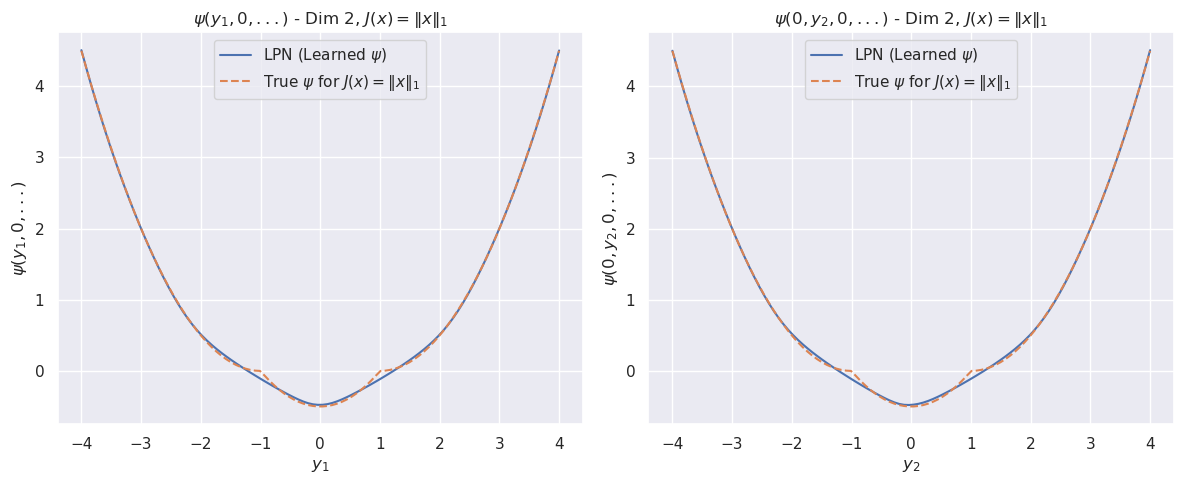

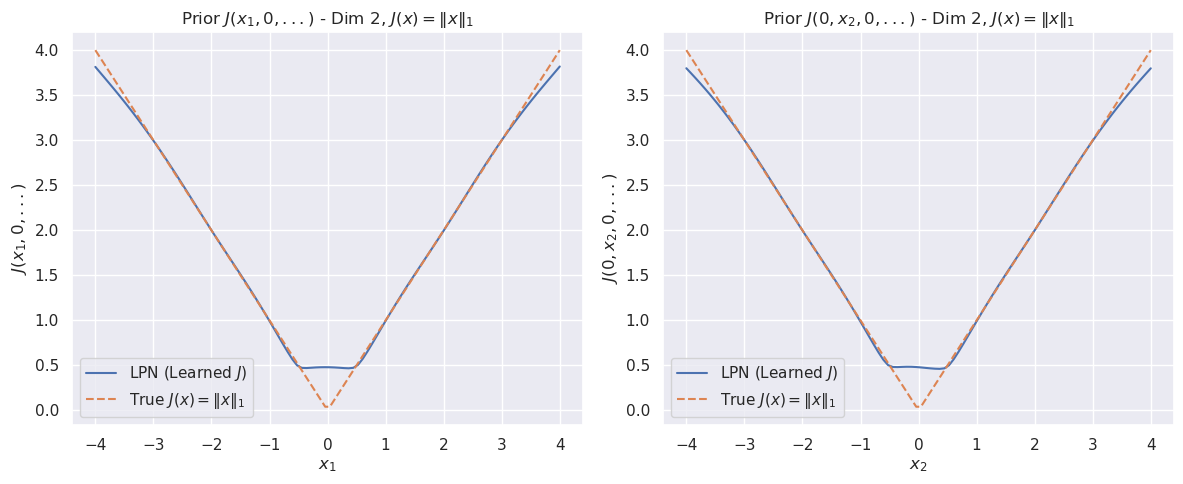

In [8]:
# L1 loss -- Plot
plot_all_quadratic_l1(lpn_model_quad_l1, a_exp, spacing, INVERT_MODE, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

psi_x_k = lpn_model_quad_l1.scalar(x_k_tensor)

y_k_tensor = lpn_model_quad_l1(x_k_tensor)

inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

tensor([[-0.4328,  0.7107],
        [-3.1183, -0.6271],
        [-1.8257, -2.2611],
        ...,
        [-1.6852,  0.4711],
        [-2.4693,  0.5375],
        [ 0.4481, -1.0112]], device='cuda:0')

In [10]:
# --- Step 3: Train 2nd LPN ---
print("\n--- Training Second LPN for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=1, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN for Concave Quadratic Prior ---
iteration 0 loss 4.301525115966797
iteration 0 loss 455.3554382324219


iteration 500 loss 2.3225181102752686


iteration 1000 loss 1.6661561727523804


iteration 1500 loss 1.3599908351898193


iteration 2000 loss 0.9438767433166504


iteration 2500 loss 0.5663321018218994


iteration 3000 loss 0.2888301610946655


iteration 3500 loss 0.12266290187835693


iteration 4000 loss 0.047103289514780045


iteration 4500 loss 0.021485695615410805


iteration 5000 loss 0.013503643684089184


iteration 5500 loss 0.009813806973397732


iteration 6000 loss 0.00765743525698781


iteration 6500 loss 0.006412238348275423


iteration 7000 loss 0.005611768923699856


iteration 7500 loss 0.004981136415153742


iteration 8000 loss 0.0044128913432359695


iteration 8500 loss 0.003916632849723101


iteration 9000 loss 0.003463768633082509


iteration 9500 loss 0.003073466708883643


iteration 10000 loss 0.002720762975513935


iteration 10500 loss 0.0024194095749408007


iteration 11000 loss 0.002154973102733493


iteration 11500 loss 0.0019316701218485832


iteration 12000 loss 0.0017355167074128985


iteration 12500 loss 0.0019339877180755138


iteration 13000 loss 0.0014774221926927567


iteration 13500 loss 0.0013930259738117456


iteration 14000 loss 0.00130665791220963


iteration 14500 loss 0.0012349614407867193


iteration 15000 loss 0.0012034198734909296


iteration 15500 loss 0.0011689681559801102


iteration 16000 loss 0.001129576121456921


iteration 16500 loss 0.0010854422580450773


iteration 17000 loss 0.0010380891617387533


iteration 17500 loss 0.0010157800279557705


iteration 18000 loss 0.0010002508061006665


iteration 18500 loss 0.0009824649896472692


iteration 19000 loss 0.0009613118600100279


iteration 19500 loss 0.0009358312236145139


iteration 20000 loss 0.0009062602766789496


iteration 20500 loss 0.0008812641026452184


iteration 21000 loss 0.0008705789223313332


iteration 21500 loss 0.0008603225578553975


iteration 22000 loss 0.0008481246768496931


iteration 22500 loss 0.0008333019795827568


iteration 23000 loss 0.0008153525996021926


iteration 23500 loss 0.0007937480695545673


iteration 24000 loss 0.0007742434390820563


iteration 24500 loss 0.0007639960967935622


iteration 25000 loss 0.0007532336749136448


iteration 25500 loss 0.0007401227485388517


iteration 26000 loss 0.0007242094143293798


iteration 26500 loss 0.0007051311549730599


iteration 27000 loss 0.0006980564212426543


iteration 27500 loss 0.0006916175480000675


iteration 28000 loss 0.0006842971197329462


iteration 28500 loss 0.0006752665503881872


iteration 29000 loss 0.0006641354411840439


iteration 29500 loss 0.000650525267701596


iteration 30000 loss 0.0006376703386195004


iteration 30500 loss 0.0006302761612460017


iteration 31000 loss 0.0006226785480976105


iteration 31500 loss 0.0006133790011517704


iteration 32000 loss 0.0006018955609761178


iteration 32500 loss 0.0007886688108555973


iteration 33000 loss 0.0005835240590386093


iteration 33500 loss 0.0005774448509328067


iteration 34000 loss 0.0005699758185073733


iteration 34500 loss 0.0005606047925539315


iteration 35000 loss 0.0005489541799761355


iteration 35500 loss 0.00054180744336918


iteration 36000 loss 0.0005370934377424419


iteration 36500 loss 0.0005315757589414716


iteration 37000 loss 0.0005246868240647018


iteration 37500 loss 0.000516092695761472


iteration 38000 loss 0.0005053898203186691


iteration 38500 loss 0.0005002300604246557


iteration 39000 loss 0.0004962034872733057


iteration 39500 loss 0.0004917348269373178


iteration 40000 loss 0.0004861751804128289


iteration 40500 loss 0.0004791693645529449


iteration 41000 loss 0.0004704371385741979


iteration 41500 loss 0.00046287989243865013


iteration 42000 loss 0.00045801085070706904


iteration 42500 loss 0.0004529579891823232


iteration 43000 loss 0.00044667947804555297


iteration 43500 loss 0.0004388082306832075


iteration 44000 loss 0.00043174828169867396


iteration 44500 loss 0.0004274129751138389


iteration 45000 loss 0.00042339018546044827


iteration 45500 loss 0.0004183884884696454


iteration 46000 loss 0.00041208771290257573


iteration 46500 loss 0.0004041239735670388


iteration 47000 loss 0.0003986643278039992


iteration 47500 loss 0.0003948788798879832


iteration 48000 loss 0.00039097515400499105


iteration 48500 loss 0.00038611862692050636


iteration 49000 loss 0.0003799884289037436


iteration 49500 loss 0.0003722584224306047


iteration 50000 loss 0.00036797928623855114


iteration 50500 loss 0.00036494809319265187


iteration 51000 loss 0.00036151069798506796


iteration 51500 loss 0.00035720347659662366


iteration 52000 loss 0.0003517695004120469


iteration 52500 loss 0.0003448787028901279


iteration 53000 loss 0.0003396696993149817


iteration 53500 loss 0.0003364960430189967


iteration 54000 loss 0.00033362439717166126


iteration 54500 loss 0.00033008825266733766


iteration 55000 loss 0.0003256395866628736


iteration 55500 loss 0.00032003317028284073


iteration 56000 loss 0.000313262251438573


iteration 56500 loss 0.0003111656988039613


iteration 57000 loss 0.00030834419885650277


iteration 57500 loss 0.00030498282285407186


iteration 58000 loss 0.0003007861669175327


iteration 58500 loss 0.0002955153468064964


iteration 59000 loss 0.0007877249154262245


iteration 59500 loss 0.000288040260784328


iteration 60000 loss 0.0002857481886167079


iteration 60500 loss 0.00028310451307334006


iteration 61000 loss 0.00027981773018836975


iteration 61500 loss 0.00027568842051550746


iteration 62000 loss 0.0002705025253817439


iteration 62500 loss 0.0002669116365723312


iteration 63000 loss 0.00026442972011864185


iteration 63500 loss 0.00026223051827400923


iteration 64000 loss 0.00025953431031666696


iteration 64500 loss 0.00025614185142330825


iteration 65000 loss 0.0002518795372452587


iteration 65500 loss 0.00024655487504787743


iteration 66000 loss 0.0002450701140332967


iteration 66500 loss 0.0002432102191960439


iteration 67000 loss 0.00024111327365972102


iteration 67500 loss 0.0002385106054134667


iteration 68000 loss 0.0002352406008867547


iteration 68500 loss 0.00023113655333872885


iteration 69000 loss 0.00022936421737540513


iteration 69500 loss 0.00022591576271224767


iteration 70000 loss 0.00022417554282583296


iteration 70500 loss 0.00022217516379896551


iteration 71000 loss 0.00021970318630337715


iteration 71500 loss 0.0002166111662518233


iteration 72000 loss 0.0002127325424226001


iteration 72500 loss 0.00021044843015260994


iteration 73000 loss 0.00020842628146056086


iteration 73500 loss 0.0002068304893327877


iteration 74000 loss 0.00020492028852459043


iteration 74500 loss 0.00020253016555216163


iteration 75000 loss 0.00019952621369156986


iteration 75500 loss 0.00019576451450120658


iteration 76000 loss 0.00019375505507923663


iteration 76500 loss 0.00019191957835573703


iteration 77000 loss 0.00018989543605130166


iteration 77500 loss 0.00018738389189820737


iteration 78000 loss 0.00018423698202241212


iteration 78500 loss 0.00018287259445060045


iteration 79000 loss 0.00018014658417087048


iteration 79500 loss 0.00017864648543763906


iteration 80000 loss 0.0001769023947417736


iteration 80500 loss 0.0001747433707350865


iteration 81000 loss 0.0001720423751976341


iteration 81500 loss 0.00016866420628502965


iteration 82000 loss 0.00016829017840791494


iteration 82500 loss 0.00016699425759725273


iteration 83000 loss 0.00016565674741286784


iteration 83500 loss 0.00016403014888055623


iteration 84000 loss 0.0001619987015146762


iteration 84500 loss 0.0001594539062352851


iteration 85000 loss 0.00021302749519236386


iteration 85500 loss 0.0001555877097416669


iteration 86000 loss 0.00015412483480758965


iteration 86500 loss 0.00015239743515849113


iteration 87000 loss 0.00015026285836938769


iteration 87500 loss 0.00014758481120225042


iteration 88000 loss 0.00014693096454720944


iteration 88500 loss 0.00014568118785973638


iteration 89000 loss 0.0001446193637093529


iteration 89500 loss 0.0001433762809028849


iteration 90000 loss 0.00014183844905346632


iteration 90500 loss 0.00013992520689498633


iteration 91000 loss 0.00013757520355284214


iteration 91500 loss 0.0001367146469419822


iteration 92000 loss 0.00013564321852754802


iteration 92500 loss 0.00013463351933751255


iteration 93000 loss 0.000133412831928581


iteration 93500 loss 0.00013189000310376287


iteration 94000 loss 0.00012998202873859555


iteration 94500 loss 0.00013181267422623932


iteration 95000 loss 0.00012763756967615336


iteration 95500 loss 0.0001267672050744295


iteration 96000 loss 0.00012583815259858966


iteration 96500 loss 0.00012470546062104404


iteration 97000 loss 0.00012329178571235389


iteration 97500 loss 0.0001215365991811268


iteration 98000 loss 0.00012100477033527568


iteration 98500 loss 0.00011959826952079311


iteration 99000 loss 0.00011881460522999987


iteration 99500 loss 0.00011794041347457096


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.00011686713696690276


iteration 100500 loss 0.00011673164408421144


iteration 101000 loss 0.00011655804701149464


iteration 101500 loss 0.00011633692338364199


iteration 102000 loss 0.0001160537576652132


iteration 102500 loss 0.00011569301568670198


iteration 103000 loss 0.0001152333352365531


iteration 103500 loss 0.00011464955605333671


iteration 104000 loss 0.00011391008592909202


iteration 104500 loss 0.00011297698074486107


iteration 105000 loss 0.00011180779983988032


iteration 105500 loss 0.0001103546965168789


iteration 106000 loss 0.00010889279656112194


iteration 106500 loss 0.00010830063547473401


iteration 107000 loss 0.00010756139818113297


iteration 107500 loss 0.00010663196735549718


iteration 108000 loss 0.00010547055717324838


iteration 108500 loss 0.00010403458873042837


iteration 109000 loss 0.00010307208867743611


iteration 109500 loss 0.0001026511745294556


iteration 110000 loss 0.00010211870539933443


iteration 110500 loss 0.00010144557745661587


iteration 111000 loss 0.00010059744090540335


iteration 111500 loss 9.95365044218488e-05


iteration 112000 loss 9.822152060223743e-05


iteration 112500 loss 9.730738383950666e-05


iteration 113000 loss 9.675477485870942e-05


iteration 113500 loss 9.605946979718283e-05


iteration 114000 loss 9.518625302007422e-05


iteration 114500 loss 9.409730409970507e-05


iteration 115000 loss 9.333030175184831e-05


iteration 115500 loss 9.254297037841752e-05


iteration 116000 loss 9.214755118591711e-05


iteration 116500 loss 9.164569200947881e-05


iteration 117000 loss 9.101097384700552e-05


iteration 117500 loss 9.021230653161183e-05


iteration 118000 loss 8.92143725650385e-05


iteration 118500 loss 8.897476072888821e-05


iteration 119000 loss 8.777971379458904e-05


iteration 119500 loss 8.742611680645496e-05


iteration 120000 loss 8.697705197846517e-05


iteration 120500 loss 8.640814485261217e-05


iteration 121000 loss 8.56922342791222e-05


iteration 121500 loss 8.479789539705962e-05


iteration 122000 loss 8.368806447833776e-05


iteration 122500 loss 8.339433406945318e-05


iteration 123000 loss 8.308096585096791e-05


iteration 123500 loss 8.268357487395406e-05


iteration 124000 loss 8.218012226279825e-05


iteration 124500 loss 8.15451712696813e-05


iteration 125000 loss 8.074867218965665e-05


iteration 125500 loss 7.975711196195334e-05


iteration 126000 loss 7.935776375234127e-05


iteration 126500 loss 7.898921467131004e-05


iteration 127000 loss 7.852295675547794e-05


iteration 127500 loss 7.793460827087983e-05


iteration 128000 loss 7.719638233538717e-05


iteration 128500 loss 7.627632294315845e-05


iteration 129000 loss 7.583606202388182e-05


iteration 129500 loss 7.544647087343037e-05


iteration 130000 loss 7.495388126699254e-05


iteration 130500 loss 7.433313294313848e-05


iteration 131000 loss 7.355639536399394e-05


iteration 131500 loss 7.290223584277555e-05


iteration 132000 loss 7.268186891451478e-05


iteration 132500 loss 7.240833656396717e-05


iteration 133000 loss 7.206227746792138e-05


iteration 133500 loss 7.162478868849576e-05


iteration 134000 loss 7.107292913133278e-05


iteration 134500 loss 7.038115290924907e-05


iteration 135000 loss 6.972518895054236e-05


iteration 135500 loss 6.942738400539383e-05


iteration 136000 loss 6.905449845362455e-05


iteration 136500 loss 6.858321285108104e-05


iteration 137000 loss 6.799120455980301e-05


iteration 137500 loss 6.725211278535426e-05


iteration 138000 loss 6.695155752822757e-05


iteration 138500 loss 6.674056203337386e-05


iteration 139000 loss 6.64732651785016e-05


iteration 139500 loss 6.613488949369639e-05


iteration 140000 loss 6.570628465851769e-05


iteration 140500 loss 6.5166263084393e-05


iteration 141000 loss 6.448956264648587e-05


iteration 141500 loss 6.415883399313316e-05


iteration 142000 loss 6.397283141268417e-05


iteration 142500 loss 6.373785436153412e-05


iteration 143000 loss 6.343960558297113e-05


iteration 143500 loss 6.306135765044019e-05


iteration 144000 loss 6.258366192923859e-05


iteration 144500 loss 6.198392657097429e-05


iteration 145000 loss 6.155898154247552e-05


iteration 145500 loss 6.138883327366784e-05


iteration 146000 loss 6.117722659837455e-05


iteration 146500 loss 6.090817987569608e-05


iteration 147000 loss 6.056657730368897e-05


iteration 147500 loss 6.013438542140648e-05


iteration 148000 loss 5.95907804381568e-05


iteration 148500 loss 5.915371002629399e-05


iteration 149000 loss 5.896784568903968e-05


iteration 149500 loss 5.873657210031524e-05


iteration 150000 loss 5.844327824888751e-05


iteration 150500 loss 5.8071742387255654e-05


iteration 151000 loss 5.760373824159615e-05


iteration 151500 loss 5.7020770327653736e-05


iteration 152000 loss 5.6832210248103365e-05


iteration 152500 loss 5.660243914462626e-05


iteration 153000 loss 5.631119347526692e-05


iteration 153500 loss 5.5942306062206626e-05


iteration 154000 loss 5.547746332013048e-05


iteration 154500 loss 5.502722706296481e-05


iteration 155000 loss 5.488709211931564e-05


iteration 155500 loss 5.471854092320427e-05


iteration 156000 loss 5.450407843454741e-05


iteration 156500 loss 5.4231637477641925e-05


iteration 157000 loss 5.388667341321707e-05


iteration 157500 loss 5.3451240091817454e-05


iteration 158000 loss 5.3025156375952065e-05


iteration 158500 loss 5.2891336963512003e-05


iteration 159000 loss 5.2739476814167574e-05


iteration 159500 loss 5.25469658896327e-05


iteration 160000 loss 5.230200258665718e-05


iteration 160500 loss 5.1991311920573935e-05


iteration 161000 loss 5.159842112334445e-05


iteration 161500 loss 5.124446761328727e-05


iteration 162000 loss 5.1027691370109096e-05


iteration 162500 loss 5.088454418000765e-05


iteration 163000 loss 5.0703285523923114e-05


iteration 163500 loss 5.047241211286746e-05


iteration 164000 loss 5.017954754293896e-05


iteration 164500 loss 4.980915036867373e-05


iteration 165000 loss 5.3710024076281115e-05


iteration 165500 loss 4.9264472181675956e-05


iteration 166000 loss 4.91404025524389e-05


iteration 166500 loss 4.8983307351591066e-05


iteration 167000 loss 4.8783313104650006e-05


iteration 167500 loss 4.852903293794952e-05


iteration 168000 loss 4.820693357032724e-05


iteration 168500 loss 4.78022157039959e-05


iteration 169000 loss 4.759976582136005e-05


iteration 169500 loss 4.748498758999631e-05


iteration 170000 loss 4.73403706564568e-05


iteration 170500 loss 4.715659451903775e-05


iteration 171000 loss 4.692267975769937e-05


iteration 171500 loss 4.662649371312e-05


iteration 172000 loss 4.625261135515757e-05


iteration 172500 loss 4.601474938681349e-05


iteration 173000 loss 4.591060132952407e-05


iteration 173500 loss 4.578166044666432e-05


iteration 174000 loss 4.561790046864189e-05


iteration 174500 loss 4.540937879937701e-05


iteration 175000 loss 4.514470128924586e-05


iteration 175500 loss 4.480973075260408e-05


iteration 176000 loss 4.4547276047524065e-05


iteration 176500 loss 4.444335718289949e-05


iteration 177000 loss 4.431355409906246e-05


iteration 177500 loss 4.4148549932288006e-05


iteration 178000 loss 4.393859489937313e-05


iteration 178500 loss 4.3672131141647696e-05


iteration 179000 loss 4.333512333687395e-05


iteration 179500 loss 4.312767123337835e-05


iteration 180000 loss 4.303474270273e-05


iteration 180500 loss 4.29196807090193e-05


iteration 181000 loss 4.277352127246559e-05


iteration 181500 loss 4.258720582583919e-05


iteration 182000 loss 4.235022424836643e-05


iteration 182500 loss 4.2050440242746845e-05


iteration 183000 loss 4.1772214899538085e-05


iteration 183500 loss 4.167279621469788e-05


iteration 184000 loss 4.1558185330359265e-05


iteration 184500 loss 4.14129244745709e-05


iteration 185000 loss 4.1228086047340184e-05


iteration 185500 loss 4.0993290895130485e-05


iteration 186000 loss 4.069591159350239e-05


iteration 186500 loss 4.047870606882498e-05


iteration 187000 loss 4.039410487166606e-05


iteration 187500 loss 4.029082992929034e-05


iteration 188000 loss 4.015971353510395e-05


iteration 188500 loss 3.999271575594321e-05


iteration 189000 loss 3.978066524723545e-05


iteration 189500 loss 3.951202961616218e-05


iteration 190000 loss 3.926712815882638e-05


iteration 190500 loss 3.918504444300197e-05


iteration 191000 loss 3.909399310941808e-05


iteration 191500 loss 3.897834540111944e-05


iteration 192000 loss 3.883137469529174e-05


iteration 192500 loss 3.864463360514492e-05


iteration 193000 loss 3.8407866668421775e-05


iteration 193500 loss 3.810932321357541e-05


iteration 194000 loss 3.8039463106542826e-05


iteration 194500 loss 3.7958394386805594e-05


iteration 195000 loss 3.785625449381769e-05


iteration 195500 loss 3.772656054934487e-05


iteration 196000 loss 3.756177466129884e-05


iteration 196500 loss 3.735291102202609e-05


iteration 197000 loss 3.708942676894367e-05


iteration 197500 loss 3.6945450119674206e-05


iteration 198000 loss 3.686013224069029e-05


iteration 198500 loss 3.6753575841430575e-05


iteration 199000 loss 3.661878145067021e-05


iteration 199500 loss 3.6447469028644264e-05


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 3.62306454917416e-05


iteration 200500 loss 3.6202767660142854e-05


iteration 201000 loss 3.616758476709947e-05


iteration 201500 loss 3.612280488596298e-05


iteration 202000 loss 3.6066805478185415e-05


iteration 202500 loss 3.5997167287860066e-05


iteration 203000 loss 3.591066342778504e-05


iteration 203500 loss 3.580453267204575e-05


iteration 204000 loss 3.567606472643092e-05


iteration 204500 loss 3.552276029950008e-05


iteration 205000 loss 3.534202551236376e-05


iteration 205500 loss 3.521430699038319e-05


iteration 206000 loss 3.508701774990186e-05


iteration 206500 loss 3.4935728763230145e-05


iteration 207000 loss 3.4765616874210536e-05


iteration 207500 loss 3.4684071579249576e-05


iteration 208000 loss 3.458516948739998e-05


iteration 208500 loss 3.4465778298908845e-05


iteration 209000 loss 3.432346784393303e-05


iteration 209500 loss 3.415542596485466e-05


iteration 210000 loss 3.407459007576108e-05


iteration 210500 loss 3.398563785594888e-05


iteration 211000 loss 3.3878979593282565e-05


iteration 211500 loss 3.375015876372345e-05


iteration 212000 loss 3.3597789297346026e-05


iteration 212500 loss 3.347328311065212e-05


iteration 213000 loss 3.337168527650647e-05


iteration 213500 loss 3.324872886878438e-05


iteration 214000 loss 3.31034061673563e-05


iteration 214500 loss 3.298111550975591e-05


iteration 215000 loss 3.288525476818904e-05


iteration 215500 loss 3.2769530662335455e-05


iteration 216000 loss 3.2632069633109495e-05


iteration 216500 loss 3.250626105000265e-05


iteration 217000 loss 3.2426334655610844e-05


iteration 217500 loss 3.233036841265857e-05


iteration 218000 loss 3.2214342354563996e-05


iteration 218500 loss 3.207684858352877e-05


iteration 219000 loss 3.1961542845238e-05


iteration 219500 loss 3.188059781678021e-05


iteration 220000 loss 3.1783329177415e-05


iteration 220500 loss 3.166604437865317e-05


iteration 221000 loss 3.152731369482353e-05


iteration 221500 loss 3.144217771477997e-05


iteration 222000 loss 3.136699160677381e-05


iteration 222500 loss 3.127647869405337e-05


iteration 223000 loss 3.116723746643402e-05


iteration 223500 loss 3.103745621046983e-05


iteration 224000 loss 3.092568294960074e-05


iteration 224500 loss 3.0835151846986264e-05


iteration 225000 loss 3.072570325457491e-05


iteration 225500 loss 3.059614391531795e-05


iteration 226000 loss 3.0496035833493806e-05


iteration 226500 loss 3.040543379029259e-05


iteration 227000 loss 3.0296065233414993e-05


iteration 227500 loss 3.0166571377776563e-05


iteration 228000 loss 3.0079461794230156e-05


iteration 228500 loss 2.9994123906362802e-05


iteration 229000 loss 2.9891090889577754e-05


iteration 229500 loss 2.97684073302662e-05


iteration 230000 loss 2.9681803425773978e-05


iteration 230500 loss 2.9618720873259008e-05


iteration 231000 loss 2.9541626645368524e-05


iteration 231500 loss 2.9448841814883053e-05


iteration 232000 loss 2.933742325694766e-05


iteration 232500 loss 2.92205331788864e-05


iteration 233000 loss 2.916187258961145e-05


iteration 233500 loss 2.908932583522983e-05


iteration 234000 loss 2.9002505470998585e-05


iteration 234500 loss 2.8897398806293495e-05


iteration 235000 loss 2.877287806768436e-05


iteration 235500 loss 2.8709428079309873e-05


iteration 236000 loss 2.8635864509851672e-05


iteration 236500 loss 2.854745980584994e-05


iteration 237000 loss 2.8441150789149106e-05


iteration 237500 loss 2.833093276422005e-05


iteration 238000 loss 2.8269292670302093e-05


iteration 238500 loss 2.8194108381285332e-05


iteration 239000 loss 2.810350815707352e-05


iteration 239500 loss 2.7994870833936147e-05


iteration 240000 loss 2.7906538889510557e-05


iteration 240500 loss 2.785136894090101e-05


iteration 241000 loss 2.778352063614875e-05


iteration 241500 loss 2.7701848011929542e-05


iteration 242000 loss 2.7603058697422966e-05


iteration 242500 loss 2.7494441383169033e-05


iteration 243000 loss 2.74387657555053e-05


iteration 243500 loss 2.737647264439147e-05


iteration 244000 loss 2.730060077738017e-05


iteration 244500 loss 2.7209302061237395e-05


iteration 245000 loss 2.7099942599306814e-05


iteration 245500 loss 2.7034675440518185e-05


iteration 246000 loss 2.697976196941454e-05


iteration 246500 loss 2.6912259272648953e-05


iteration 247000 loss 2.6831119612324983e-05


iteration 247500 loss 2.6733103368314914e-05


iteration 248000 loss 2.6634090318111703e-05


iteration 248500 loss 2.657224831636995e-05


iteration 249000 loss 2.649733141879551e-05


iteration 249500 loss 2.6406853066873737e-05


iteration 250000 loss 2.629887603688985e-05


iteration 250500 loss 2.6233195967506617e-05


iteration 251000 loss 2.6159545086557046e-05


iteration 251500 loss 2.607072747196071e-05


iteration 252000 loss 2.596454942249693e-05


iteration 252500 loss 2.5913997887982987e-05


iteration 253000 loss 2.5865934730973095e-05


iteration 253500 loss 2.5807183192227967e-05


iteration 254000 loss 2.573546953499317e-05


iteration 254500 loss 2.5649213057477027e-05


iteration 255000 loss 2.554607272031717e-05


iteration 255500 loss 2.5496008674963377e-05


iteration 256000 loss 2.5447314328630455e-05


iteration 256500 loss 2.5387775167473592e-05


iteration 257000 loss 2.5315415769000538e-05


iteration 257500 loss 2.522861359466333e-05


iteration 258000 loss 2.5263121642637998e-05


iteration 258500 loss 2.5086917958105914e-05


iteration 259000 loss 2.5037579689524136e-05


iteration 259500 loss 2.4977251086966135e-05


iteration 260000 loss 2.4904284146032296e-05


iteration 260500 loss 2.481644696672447e-05


iteration 261000 loss 2.4730214136070572e-05


iteration 261500 loss 2.4690998543519527e-05


iteration 262000 loss 2.46425588557031e-05


iteration 262500 loss 2.45833598455647e-05


iteration 263000 loss 2.451189538987819e-05


iteration 263500 loss 2.4426079107797705e-05


iteration 264000 loss 2.4345910787815228e-05


iteration 264500 loss 2.4307890271302313e-05


iteration 265000 loss 2.4260772988782264e-05


iteration 265500 loss 2.4203307475545444e-05


iteration 266000 loss 2.413396396150347e-05


iteration 266500 loss 2.405084524070844e-05


iteration 267000 loss 2.397665593889542e-05


iteration 267500 loss 2.3939724997035228e-05


iteration 268000 loss 2.3894166588434018e-05


iteration 268500 loss 2.3838589186198078e-05


iteration 269000 loss 2.377148121013306e-05


iteration 269500 loss 2.36910636886023e-05


iteration 270000 loss 2.3620223146281205e-05


iteration 270500 loss 2.3578553737024777e-05


iteration 271000 loss 2.3527632947661914e-05


iteration 271500 loss 2.346580549783539e-05


iteration 272000 loss 2.339179081900511e-05


iteration 272500 loss 2.3311642507906072e-05


iteration 273000 loss 2.3264017727342434e-05


iteration 273500 loss 2.3205915567814372e-05


iteration 274000 loss 2.3136377421906218e-05


iteration 274500 loss 2.307033537363168e-05


iteration 275000 loss 2.3025006157695316e-05


iteration 275500 loss 2.2988373530097306e-05


iteration 276000 loss 2.2943633666727692e-05


iteration 276500 loss 2.2888689272804186e-05


iteration 277000 loss 2.282306923007127e-05


iteration 277500 loss 2.274437792948447e-05


iteration 278000 loss 2.2706906747771427e-05


iteration 278500 loss 2.2668862584396265e-05


iteration 279000 loss 2.2622298274654895e-05


iteration 279500 loss 2.2565684048458934e-05


iteration 280000 loss 2.2497770260088146e-05


iteration 280500 loss 2.2433050617109984e-05


iteration 281000 loss 2.2399790395866148e-05


iteration 281500 loss 2.2358770365826786e-05


iteration 282000 loss 2.2308589905151166e-05


iteration 282500 loss 2.224834133812692e-05


iteration 283000 loss 2.217580367869232e-05


iteration 283500 loss 2.213742845924571e-05


iteration 284000 loss 2.2103771698311903e-05


iteration 284500 loss 2.2062497009756044e-05


iteration 285000 loss 2.201171992055606e-05


iteration 285500 loss 2.195081651734654e-05


iteration 286000 loss 2.188574399042409e-05


iteration 286500 loss 2.1848072719876654e-05


iteration 287000 loss 2.1809100871905684e-05


iteration 287500 loss 2.176141606469173e-05


iteration 288000 loss 2.1704050595872104e-05


iteration 288500 loss 2.1635085431626067e-05


iteration 289000 loss 2.160303120035678e-05


iteration 289500 loss 2.1573427147814073e-05


iteration 290000 loss 2.1537000066018663e-05


iteration 290500 loss 2.149247120541986e-05


iteration 291000 loss 2.1438383555505425e-05


iteration 291500 loss 2.13733746932121e-05


iteration 292000 loss 2.133228008460719e-05


iteration 292500 loss 2.1304645997588523e-05


iteration 293000 loss 2.12706745514879e-05


iteration 293500 loss 2.1229006961220875e-05


iteration 294000 loss 2.1178057068027556e-05


iteration 294500 loss 2.111695175699424e-05


iteration 295000 loss 2.106391366396565e-05


iteration 295500 loss 2.1032839867984876e-05


iteration 296000 loss 2.0994539227103814e-05


iteration 296500 loss 2.0947414668626152e-05


iteration 297000 loss 2.0890942323603667e-05


iteration 297500 loss 2.0831741494475864e-05


iteration 298000 loss 2.0806532120332122e-05


iteration 298500 loss 2.0775458324351348e-05


iteration 299000 loss 2.0737199520226568e-05


iteration 299500 loss 2.0690187739091925e-05


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 2.063380816252902e-05


iteration 300500 loss 2.0627068806788884e-05


iteration 301000 loss 2.061867417069152e-05


iteration 301500 loss 2.0608456907211803e-05


iteration 302000 loss 2.059625694528222e-05


iteration 302500 loss 2.058224708889611e-05


iteration 303000 loss 2.0566432795021683e-05


iteration 303500 loss 2.0548864995362237e-05


iteration 304000 loss 2.052941817964893e-05


iteration 304500 loss 2.0507839508354664e-05


iteration 305000 loss 2.0484108972596005e-05


iteration 305500 loss 2.045899054792244e-05


iteration 306000 loss 2.0434006728464738e-05


iteration 306500 loss 2.0409363060025498e-05


iteration 307000 loss 2.0384968593134545e-05


iteration 307500 loss 2.036065052379854e-05


iteration 308000 loss 2.033655073319096e-05


iteration 308500 loss 2.031257827184163e-05


iteration 309000 loss 2.0288705854909495e-05


iteration 309500 loss 2.026501897489652e-05


iteration 310000 loss 2.02414103114279e-05


iteration 310500 loss 2.0218025383655913e-05


iteration 311000 loss 2.0194765966152772e-05


iteration 311500 loss 2.0171442884020507e-05


iteration 312000 loss 2.0148250769125298e-05


iteration 312500 loss 2.0125149603700265e-05


iteration 313000 loss 2.0102050257264636e-05


iteration 313500 loss 2.0079005480511114e-05


iteration 314000 loss 2.0056007997482084e-05


iteration 314500 loss 2.0033139662700705e-05


iteration 315000 loss 2.0010440493933856e-05


iteration 315500 loss 1.9987724954262376e-05


iteration 316000 loss 1.9965003957622685e-05


iteration 316500 loss 1.994239391933661e-05


iteration 317000 loss 1.9919880287488922e-05


iteration 317500 loss 1.9897395759471692e-05


iteration 318000 loss 1.98749312403379e-05


iteration 318500 loss 1.985249764402397e-05


iteration 319000 loss 1.9830140445264988e-05


iteration 319500 loss 1.980791421374306e-05


iteration 320000 loss 1.9785693439189345e-05


iteration 320500 loss 1.976357089006342e-05


iteration 321000 loss 1.974144106497988e-05


iteration 321500 loss 1.9719367628567852e-05


iteration 322000 loss 1.9697474272106774e-05


iteration 322500 loss 1.9675477233249694e-05


iteration 323000 loss 1.9653569324873388e-05


iteration 323500 loss 1.9631772374850698e-05


iteration 324000 loss 1.9609988157753833e-05


iteration 324500 loss 1.958827670023311e-05


iteration 325000 loss 1.9566627088352107e-05


iteration 325500 loss 1.9545008399290964e-05


iteration 326000 loss 1.952339880517684e-05


iteration 326500 loss 1.9501907445373945e-05


iteration 327000 loss 1.9480450646369718e-05


iteration 327500 loss 1.9459041141089983e-05


iteration 328000 loss 1.9437577066128142e-05


iteration 328500 loss 1.9416260329307988e-05


iteration 329000 loss 1.9395001800148748e-05


iteration 329500 loss 1.937375054694712e-05


iteration 330000 loss 1.935259933816269e-05


iteration 330500 loss 1.9331455405335873e-05


iteration 331000 loss 1.9310416973894462e-05


iteration 331500 loss 1.928944948303979e-05


iteration 332000 loss 1.9268512915004976e-05


iteration 332500 loss 1.9247609088779427e-05


iteration 333000 loss 1.922679803101346e-05


iteration 333500 loss 1.9206016077077948e-05


iteration 334000 loss 1.9185268683941104e-05


iteration 334500 loss 1.916463952511549e-05


iteration 335000 loss 1.9143979443470016e-05


iteration 335500 loss 1.9123413949273527e-05


iteration 336000 loss 1.910289029183332e-05


iteration 336500 loss 1.9082404833170585e-05


iteration 337000 loss 1.9061937564401887e-05


iteration 337500 loss 1.904156852106098e-05


iteration 338000 loss 1.902124313346576e-05


iteration 338500 loss 1.9001023247255944e-05


iteration 339000 loss 1.8980714230565354e-05


iteration 339500 loss 1.896056710393168e-05


iteration 340000 loss 1.894059096230194e-05


iteration 340500 loss 1.892050750029739e-05


iteration 341000 loss 1.8900451323133893e-05


iteration 341500 loss 1.888050428533461e-05


iteration 342000 loss 1.8860466298065148e-05


iteration 342500 loss 1.8840730263036676e-05


iteration 343000 loss 1.882095239125192e-05


iteration 343500 loss 1.8801018086378463e-05


iteration 344000 loss 1.8781131075229496e-05


iteration 344500 loss 1.8761676983558573e-05


iteration 345000 loss 1.874196641438175e-05


iteration 345500 loss 1.8722208551480435e-05


iteration 346000 loss 1.870248161139898e-05


iteration 346500 loss 1.8682816516957246e-05


iteration 347000 loss 1.866310412879102e-05


iteration 347500 loss 1.8643560906639323e-05


iteration 348000 loss 1.8623946743900888e-05


iteration 348500 loss 1.860437259892933e-05


iteration 349000 loss 1.858484756667167e-05


iteration 349500 loss 1.856543713074643e-05


iteration 350000 loss 1.8545919374446385e-05


iteration 350500 loss 1.8526579879107885e-05


iteration 351000 loss 1.8507162167225033e-05


iteration 351500 loss 1.8487860870664008e-05


iteration 352000 loss 1.8468610505806282e-05


iteration 352500 loss 1.8449334675096907e-05


iteration 353000 loss 1.8430080672260374e-05


iteration 353500 loss 1.8410963093629107e-05


iteration 354000 loss 1.839178912632633e-05


iteration 354500 loss 1.8372747945250012e-05


iteration 355000 loss 1.835371585912071e-05


iteration 355500 loss 1.833484748203773e-05


iteration 356000 loss 1.831594272516668e-05


iteration 356500 loss 1.829696884669829e-05


iteration 357000 loss 1.8278073184774257e-05


iteration 357500 loss 1.825928848120384e-05


iteration 358000 loss 1.824039463826921e-05


iteration 358500 loss 1.822169724619016e-05


iteration 359000 loss 1.8202857972937636e-05


iteration 359500 loss 1.8184160580858588e-05


iteration 360000 loss 1.8165497749578208e-05


iteration 360500 loss 1.814688221202232e-05


iteration 361000 loss 1.8128206647816114e-05


iteration 361500 loss 1.810970570659265e-05


iteration 362000 loss 1.8091272067977116e-05


iteration 362500 loss 1.8072742022923194e-05


iteration 363000 loss 1.8054350221063942e-05


iteration 363500 loss 1.8035992980003357e-05


iteration 364000 loss 1.801757753128186e-05


iteration 364500 loss 1.7999338524532504e-05


iteration 365000 loss 1.798104858607985e-05


iteration 365500 loss 1.7962865968002006e-05


iteration 366000 loss 1.7944705177797005e-05


iteration 366500 loss 1.792666625988204e-05


iteration 367000 loss 1.7908518202602863e-05


iteration 367500 loss 1.7890461094793864e-05


iteration 368000 loss 1.7872374883154407e-05


iteration 368500 loss 1.7854383258963935e-05


iteration 369000 loss 1.7836367987911217e-05


iteration 369500 loss 1.7818443666328676e-05


iteration 370000 loss 1.7800484783947468e-05


iteration 370500 loss 1.7782595023163594e-05


iteration 371000 loss 1.7764708900358528e-05


iteration 371500 loss 1.774688826117199e-05


iteration 372000 loss 1.7729045794112608e-05


iteration 372500 loss 1.7711319742375053e-05


iteration 373000 loss 1.76936446223408e-05


iteration 373500 loss 1.7675960407359526e-05


iteration 374000 loss 1.7658319848123938e-05


iteration 374500 loss 1.764069384080358e-05


iteration 375000 loss 1.7623300664126873e-05


iteration 375500 loss 1.7605801986064762e-05


iteration 376000 loss 1.75884306372609e-05


iteration 376500 loss 1.757092832121998e-05


iteration 377000 loss 1.7553495126776397e-05


iteration 377500 loss 1.7536058294354007e-05


iteration 378000 loss 1.7518656022730283e-05


iteration 378500 loss 1.75013246916933e-05


iteration 379000 loss 1.7483973351772875e-05


iteration 379500 loss 1.7466669305576943e-05


iteration 380000 loss 1.744939618220087e-05


iteration 380500 loss 1.7432175809517503e-05


iteration 381000 loss 1.741494270390831e-05


iteration 381500 loss 1.7397802366758697e-05


iteration 382000 loss 1.7380645658704452e-05


iteration 382500 loss 1.7363539882353507e-05


iteration 383000 loss 1.7346461390843615e-05


iteration 383500 loss 1.7329410184174776e-05


iteration 384000 loss 1.731241718516685e-05


iteration 384500 loss 1.729542600514833e-05


iteration 385000 loss 1.727846210997086e-05


iteration 385500 loss 1.7261505490751006e-05


iteration 386000 loss 1.724458343232982e-05


iteration 386500 loss 1.7227694115717895e-05


iteration 387000 loss 1.721085936878808e-05


iteration 387500 loss 1.7194061001646332e-05


iteration 388000 loss 1.717727900540922e-05


iteration 388500 loss 1.7160486095235683e-05


iteration 389000 loss 1.7143722288892604e-05


iteration 389500 loss 1.712707853585016e-05


iteration 390000 loss 1.7110367480199784e-05


iteration 390500 loss 1.7093761925934814e-05


iteration 391000 loss 1.707712908682879e-05


iteration 391500 loss 1.7060530808521435e-05


iteration 392000 loss 1.7044008927769028e-05


iteration 392500 loss 1.7027417925419286e-05


iteration 393000 loss 1.701090150163509e-05


iteration 393500 loss 1.6994421457638964e-05


iteration 394000 loss 1.6978015992208384e-05


iteration 394500 loss 1.6961586879915558e-05


iteration 395000 loss 1.6945194147410803e-05


iteration 395500 loss 1.6928866898524575e-05


iteration 396000 loss 1.691251964075491e-05


iteration 396500 loss 1.689618693490047e-05


iteration 397000 loss 1.687993062660098e-05


iteration 397500 loss 1.6863667042343877e-05


iteration 398000 loss 1.684747803665232e-05


iteration 398500 loss 1.6831290849950165e-05


iteration 399000 loss 1.6815156413940713e-05


iteration 399500 loss 1.679903652984649e-05


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 1.678296939644497e-05


iteration 400500 loss 1.6782039892859757e-05


iteration 401000 loss 1.6780975784058683e-05


iteration 401500 loss 1.6779813449829817e-05


iteration 402000 loss 1.6778560166130774e-05


iteration 402500 loss 1.6777192286099307e-05


iteration 403000 loss 1.6775835320004262e-05


iteration 403500 loss 1.6774394680396654e-05


iteration 404000 loss 1.6772886738181114e-05


iteration 404500 loss 1.6771373338997364e-05


iteration 405000 loss 1.67698017321527e-05


iteration 405500 loss 1.6768213754403405e-05


iteration 406000 loss 1.676668762229383e-05


iteration 406500 loss 1.6765028703957796e-05


iteration 407000 loss 1.6763484381954186e-05


iteration 407500 loss 1.676181454968173e-05


iteration 408000 loss 1.6760237485868856e-05


iteration 408500 loss 1.675864405115135e-05


iteration 409000 loss 1.6757061530370265e-05


iteration 409500 loss 1.675540625001304e-05


iteration 410000 loss 1.675385829003062e-05


iteration 410500 loss 1.67522575793555e-05


iteration 411000 loss 1.6750655049690977e-05


iteration 411500 loss 1.6749063433962874e-05


iteration 412000 loss 1.6747530025895685e-05


iteration 412500 loss 1.674589111644309e-05


iteration 413000 loss 1.6744288586778566e-05


iteration 413500 loss 1.6742749721743166e-05


iteration 414000 loss 1.6741165381972678e-05


iteration 414500 loss 1.6739584680180997e-05


iteration 415000 loss 1.6738003978389315e-05


iteration 415500 loss 1.6736392353777774e-05


iteration 416000 loss 1.6734904420445673e-05


iteration 416500 loss 1.6733267329982482e-05


iteration 417000 loss 1.6731713913031854e-05


iteration 417500 loss 1.6730125935282558e-05


iteration 418000 loss 1.6728599803172983e-05


iteration 418500 loss 1.6727024558349513e-05


iteration 419000 loss 1.6725447494536638e-05


iteration 419500 loss 1.672382677497808e-05


iteration 420000 loss 1.672228245297447e-05


iteration 420500 loss 1.672071266511921e-05


iteration 421000 loss 1.6719161067157984e-05


iteration 421500 loss 1.671760401222855e-05


iteration 422000 loss 1.671599420660641e-05


iteration 422500 loss 1.6714468074496835e-05


iteration 423000 loss 1.6712847354938276e-05


iteration 423500 loss 1.6711308489902876e-05


iteration 424000 loss 1.6709738702047616e-05


iteration 424500 loss 1.6708198018022813e-05


iteration 425000 loss 1.6706593669368885e-05


iteration 425500 loss 1.6705029338481836e-05


iteration 426000 loss 1.6703495930414647e-05


iteration 426500 loss 1.670190795266535e-05


iteration 427000 loss 1.670040364842862e-05


iteration 427500 loss 1.669882476562634e-05


iteration 428000 loss 1.6697284081601538e-05


iteration 428500 loss 1.6695723388693295e-05


iteration 429000 loss 1.6694179066689685e-05


iteration 429500 loss 1.6692640201654285e-05


iteration 430000 loss 1.6691061318852007e-05


iteration 430500 loss 1.6689491530996747e-05


iteration 431000 loss 1.6687976312823594e-05


iteration 431500 loss 1.668642471486237e-05


iteration 432000 loss 1.6684900401742198e-05


iteration 432500 loss 1.6683345165802166e-05


iteration 433000 loss 1.6681786291883327e-05


iteration 433500 loss 1.6680278349667788e-05


iteration 434000 loss 1.6678703104844317e-05


iteration 434500 loss 1.6677182429702953e-05


iteration 435000 loss 1.6675619917805307e-05


iteration 435500 loss 1.6674121070536785e-05


iteration 436000 loss 1.6672560377628542e-05


iteration 436500 loss 1.6671037883497775e-05


iteration 437000 loss 1.6669493561494164e-05


iteration 437500 loss 1.666794742050115e-05


iteration 438000 loss 1.666639218456112e-05


iteration 438500 loss 1.666484968154691e-05


iteration 439000 loss 1.666328898863867e-05


iteration 439500 loss 1.6661804693285376e-05


iteration 440000 loss 1.666024218138773e-05


iteration 440500 loss 1.6658676031511277e-05


iteration 441000 loss 1.665719537413679e-05


iteration 441500 loss 1.6655621948302723e-05


iteration 442000 loss 1.6654097635182552e-05


iteration 442500 loss 1.6652580598019995e-05


iteration 443000 loss 1.6651076293783262e-05


iteration 443500 loss 1.664955198066309e-05


iteration 444000 loss 1.6647943994030356e-05


iteration 444500 loss 1.6646461517666467e-05


iteration 445000 loss 1.6644928109599277e-05


iteration 445500 loss 1.6643420167383738e-05


iteration 446000 loss 1.664185219851788e-05


iteration 446500 loss 1.66403224284295e-05


iteration 447000 loss 1.663881448621396e-05


iteration 447500 loss 1.663727016421035e-05


iteration 448000 loss 1.663575130805839e-05


iteration 448500 loss 1.663419789110776e-05


iteration 449000 loss 1.6632675396976992e-05


iteration 449500 loss 1.6631161997793242e-05


iteration 450000 loss 1.6629635865683667e-05


iteration 450500 loss 1.6628091543680057e-05


iteration 451000 loss 1.662657996348571e-05


iteration 451500 loss 1.6625039279460907e-05


iteration 452000 loss 1.6623529518255964e-05


iteration 452500 loss 1.66220088431146e-05


iteration 453000 loss 1.662047543504741e-05


iteration 453500 loss 1.6618954759906046e-05


iteration 454000 loss 1.6617435903754085e-05


iteration 454500 loss 1.661585883994121e-05


iteration 455000 loss 1.6614352716715075e-05


iteration 455500 loss 1.6612853869446553e-05


iteration 456000 loss 1.6611304090474732e-05


iteration 456500 loss 1.6609821614110842e-05


iteration 457000 loss 1.6608288206043653e-05


iteration 457500 loss 1.6606723875156604e-05


iteration 458000 loss 1.6605230484856293e-05


iteration 458500 loss 1.6603687981842086e-05


iteration 459000 loss 1.6602174582658336e-05


iteration 459500 loss 1.660068846831564e-05


iteration 460000 loss 1.6599102309555747e-05


iteration 460500 loss 1.659762710914947e-05


iteration 461000 loss 1.659613917581737e-05


iteration 461500 loss 1.6594598491792567e-05


iteration 462000 loss 1.659310692048166e-05


iteration 462500 loss 1.659155714150984e-05


iteration 463000 loss 1.659005465626251e-05


iteration 463500 loss 1.6588559446972795e-05


iteration 464000 loss 1.6587046047789045e-05


iteration 464500 loss 1.6585507182753645e-05


iteration 465000 loss 1.658401197346393e-05


iteration 465500 loss 1.6582480384386145e-05


iteration 466000 loss 1.65810215548845e-05


iteration 466500 loss 1.6579489965806715e-05


iteration 467000 loss 1.6577954738750122e-05


iteration 467500 loss 1.6576412235735916e-05


iteration 468000 loss 1.6574949768255465e-05


iteration 468500 loss 1.6573419998167083e-05


iteration 469000 loss 1.6571922969887964e-05


iteration 469500 loss 1.657040775171481e-05


iteration 470000 loss 1.656887798162643e-05


iteration 470500 loss 1.6567413695156574e-05


iteration 471000 loss 1.6565931218792684e-05


iteration 471500 loss 1.6564419638598338e-05


iteration 472000 loss 1.6562924429308623e-05


iteration 472500 loss 1.6561436495976523e-05


iteration 473000 loss 1.6559919458813965e-05


iteration 473500 loss 1.655846062931232e-05


iteration 474000 loss 1.6556945411139168e-05


iteration 474500 loss 1.655546475376468e-05


iteration 475000 loss 1.6553973182453774e-05


iteration 475500 loss 1.6552487068111077e-05


iteration 476000 loss 1.6551008229725994e-05


iteration 476500 loss 1.6549480278627016e-05


iteration 477000 loss 1.6548014173167758e-05


iteration 477500 loss 1.6546546248719096e-05


iteration 478000 loss 1.6545061953365803e-05


iteration 478500 loss 1.6543534002266824e-05


iteration 479000 loss 1.6542060620849952e-05


iteration 479500 loss 1.6540554497623816e-05


iteration 480000 loss 1.6539021089556627e-05


iteration 480500 loss 1.653752951824572e-05


iteration 481000 loss 1.6536068869754672e-05


iteration 481500 loss 1.6534650058019906e-05


iteration 482000 loss 1.6533109373995103e-05


iteration 482500 loss 1.6531639630557038e-05


iteration 483000 loss 1.6530144421267323e-05


iteration 483500 loss 1.6528627384104766e-05


iteration 484000 loss 1.652716673561372e-05


iteration 484500 loss 1.6525711544090882e-05


iteration 485000 loss 1.6524247257621028e-05


iteration 485500 loss 1.652273567742668e-05


iteration 486000 loss 1.652122227824293e-05


iteration 486500 loss 1.651977981964592e-05


iteration 487000 loss 1.6518317352165468e-05


iteration 487500 loss 1.65167948580347e-05


iteration 488000 loss 1.651534330449067e-05


iteration 488500 loss 1.6513826267328113e-05


iteration 489000 loss 1.651234742894303e-05


iteration 489500 loss 1.6510832210769877e-05


iteration 490000 loss 1.6509349734405987e-05


iteration 490500 loss 1.6507943655597046e-05


iteration 491000 loss 1.6506453903275542e-05


iteration 491500 loss 1.6504907762282528e-05


iteration 492000 loss 1.6503485312568955e-05


iteration 492500 loss 1.650199556024745e-05


iteration 493000 loss 1.650055855861865e-05


iteration 493500 loss 1.64990451594349e-05


iteration 494000 loss 1.6497597243869677e-05


iteration 494500 loss 1.6496107491548173e-05


iteration 495000 loss 1.6494672308908775e-05


iteration 495500 loss 1.649316618568264e-05


iteration 496000 loss 1.649169462325517e-05


iteration 496500 loss 1.6490199413965456e-05


iteration 497000 loss 1.6488793335156515e-05


iteration 497500 loss 1.6487289030919783e-05


iteration 498000 loss 1.648584657232277e-05


iteration 498500 loss 1.648434226808604e-05


iteration 499000 loss 1.6482861610711552e-05


iteration 499500 loss 1.6481437342008576e-05


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


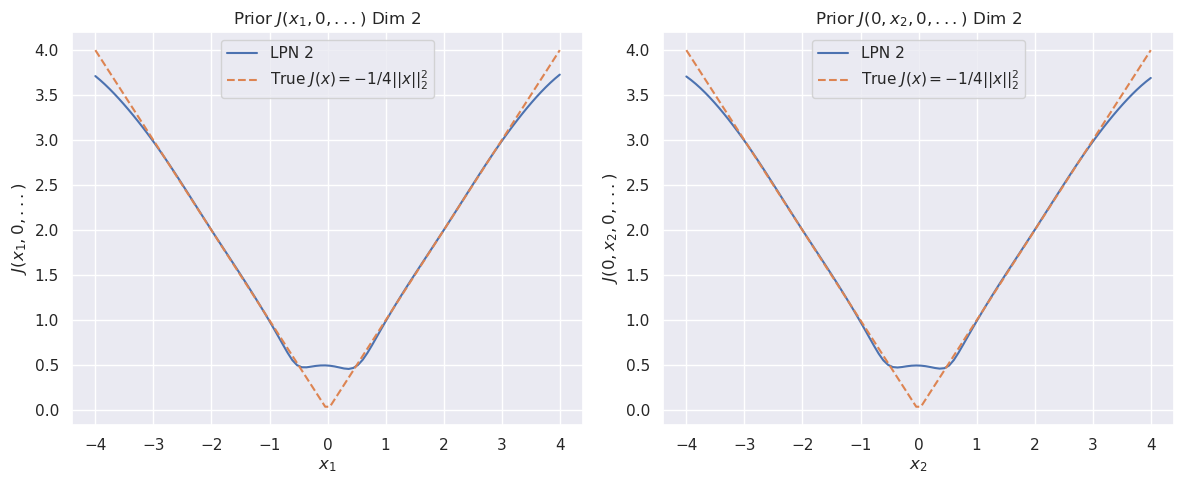

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)